# DSMCER Notebook 11 - Neural Networks

1. Anatomy of a (basic) Neural Network
    1. Neurons, layers, networks
    2. Parameters of a Neuron, activation function
    3. _Poll_: Dimensionality of hidden layers
    4. _Poll_: Picking activation function
2. Backpropegation training
    1. The loss surface
    2. Training epochs, monitoring training
    3. _Poll_: Large vs small learning rate
    4. A basic example using very nonlinear features
    5. Batching
    6. _Exercise_: Identify overfitting
    
3. Some neural network hyperparameters
    1. Network parameters
    2. _Poll_: Active region
    3. Optimization hyperparameters
    4. Regularization hyperparameters
    5. _Poll_: Advantages and disadvantages of NNs
    6. _Exercise_: Train a classifier

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.decomposition

import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

# ! NEW
import pydot
import tensorflow.keras as ks
import keras.utils.vis_utils

***
***

## 1. Anatomy of a (basic) Neural Network

### A. Neurons, layers, networks

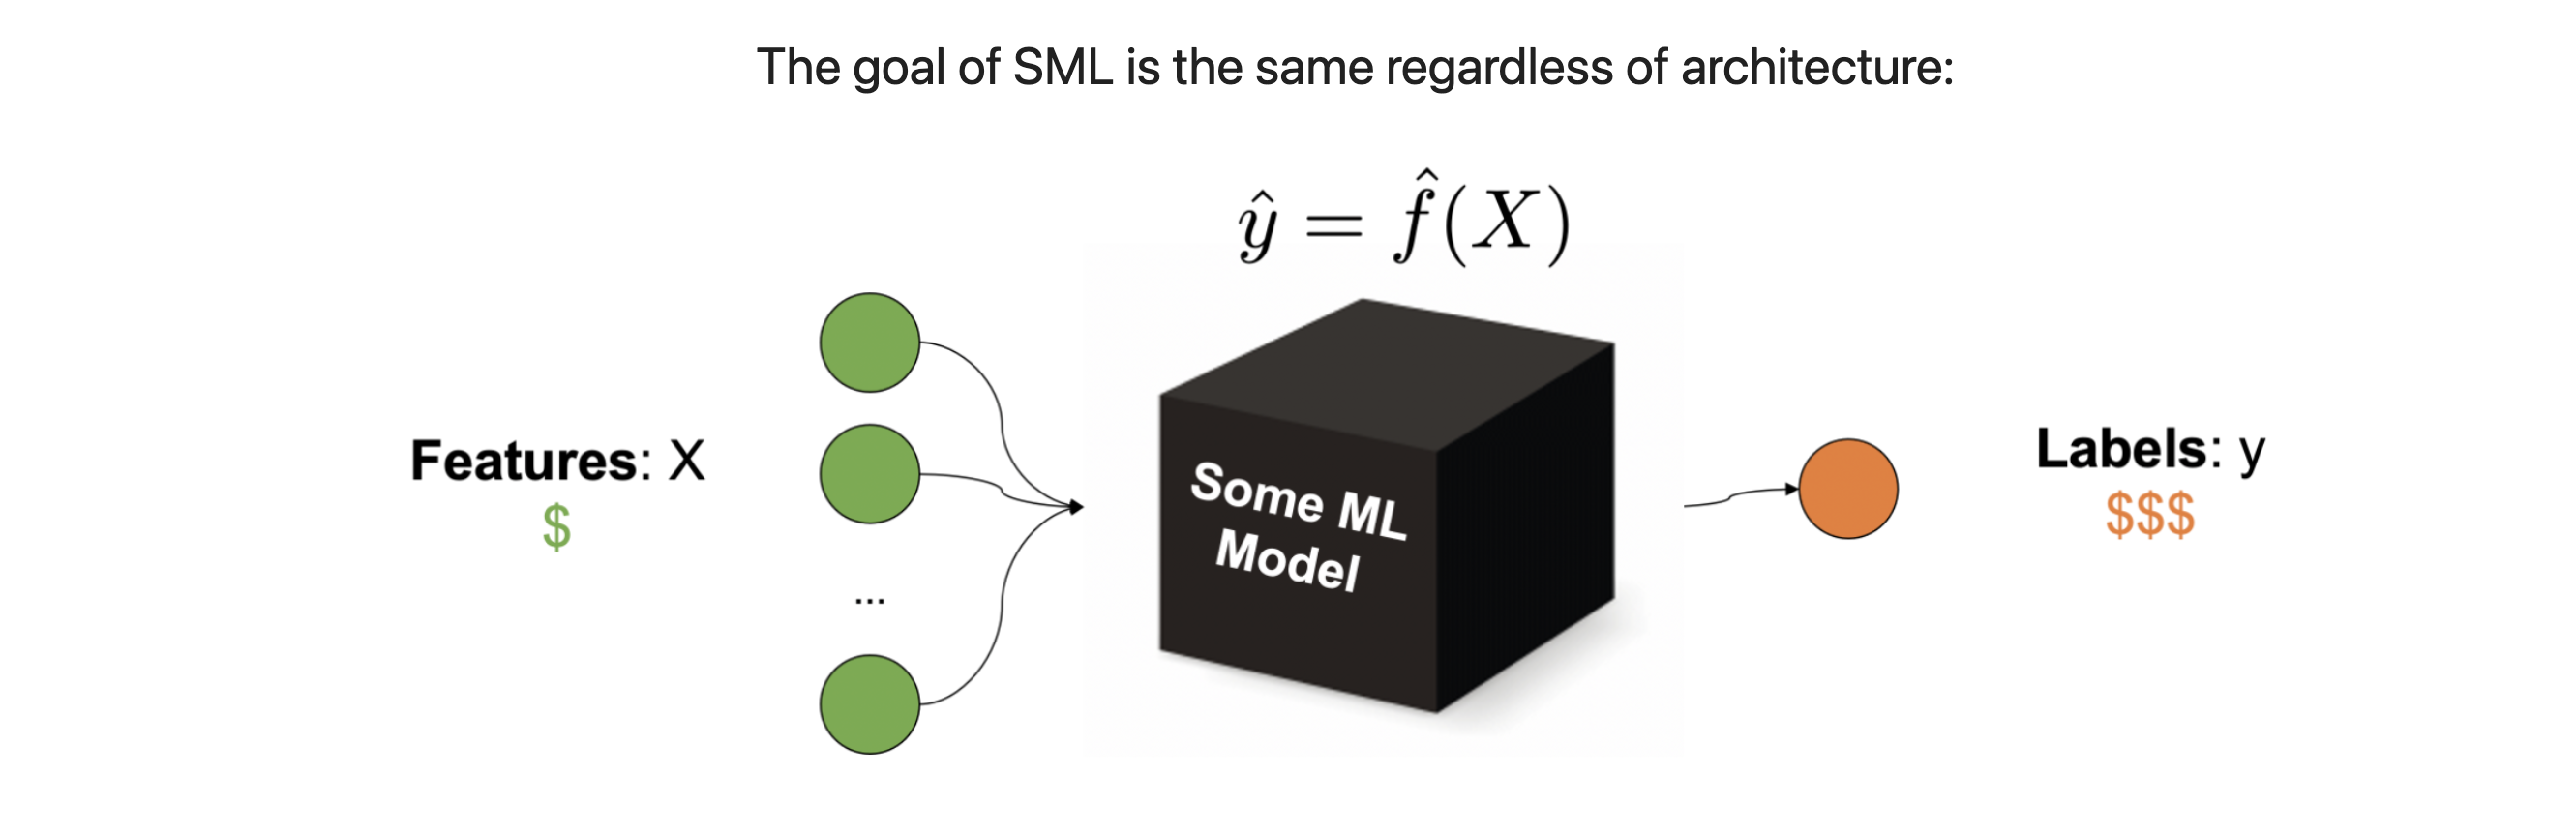

<font size=5><center> You may have heard of "Deep Learning" (eg. modeling with neural networks). __It is called deep because neural networks are highly nonlinear and extremely complex.__ They are made up of interconnected "neurons" stacked into "layers":

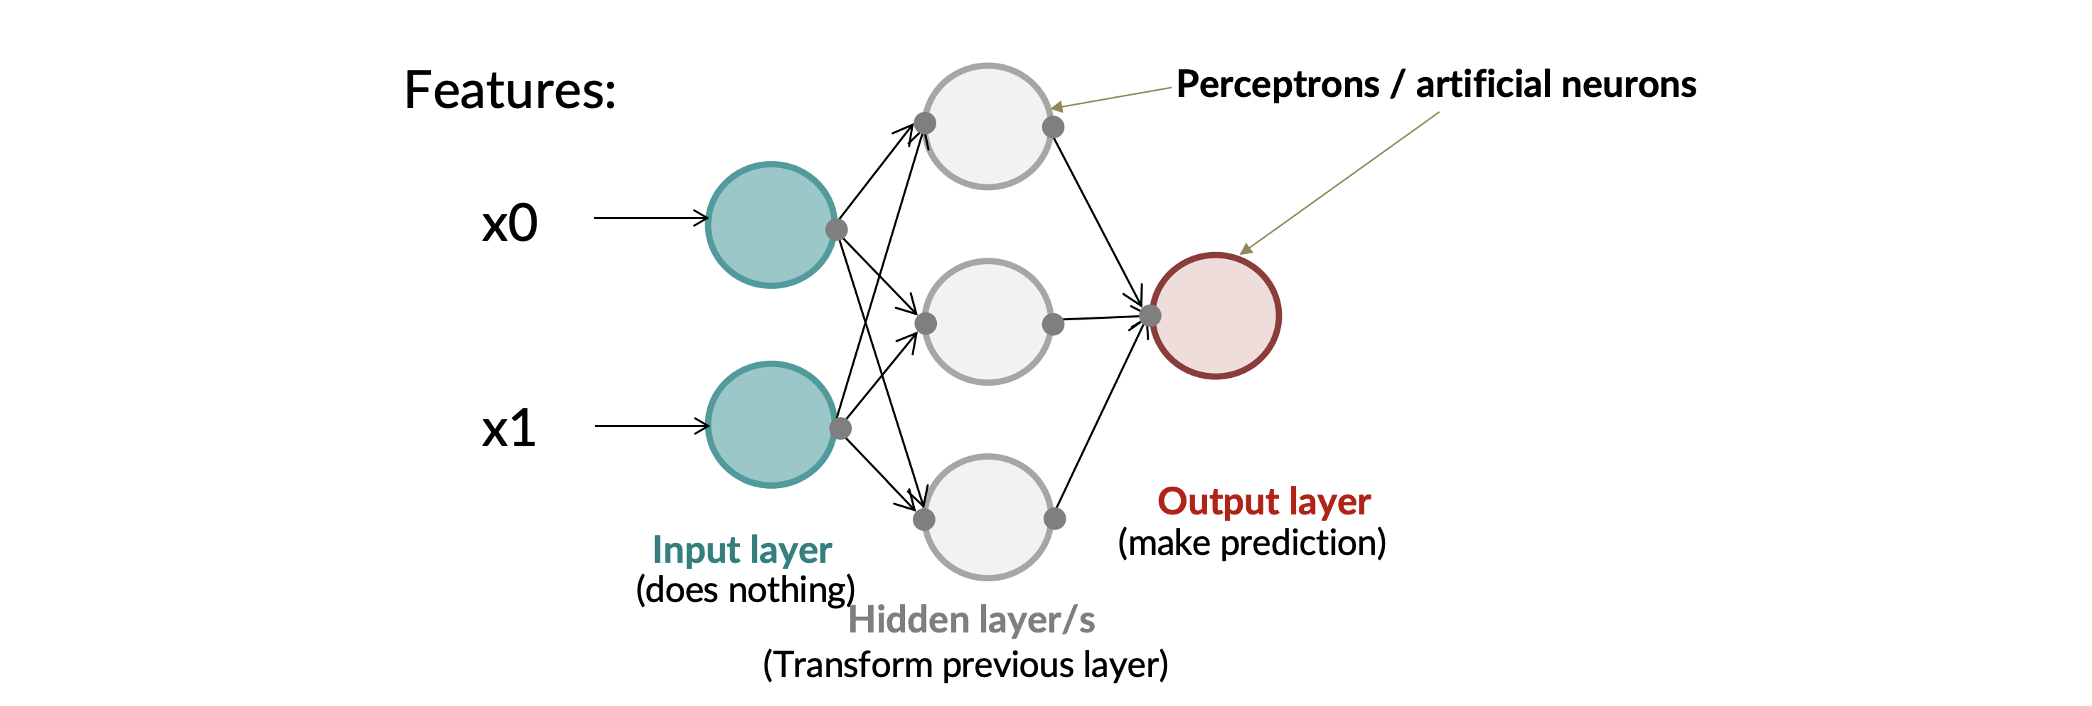

<font size=5><center>The data (X) __flows from left to right__ through the network (forward). At each step, mathematical transformations are conducted. The target is not involved yet (we will get to that).

***

<font size=4>So what are these "transformations"? Let's look at a single neuron:

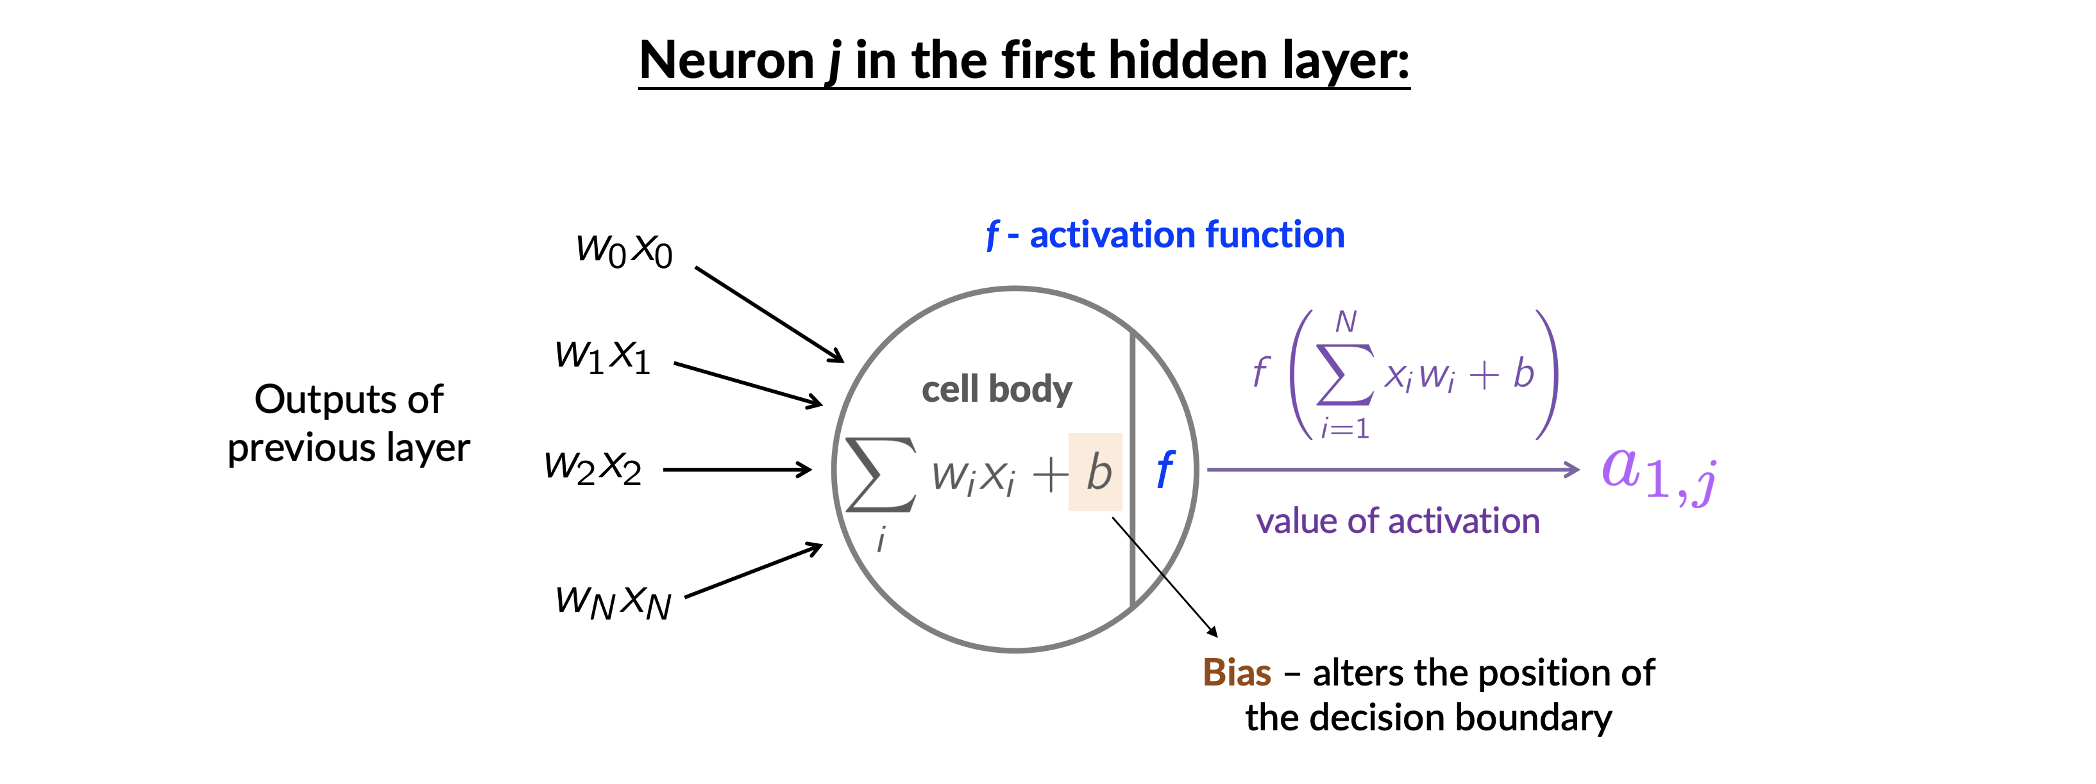

***

<font size=5><center>Activation functions are the source of the nonlinearity and happens as the last step of the neuron:

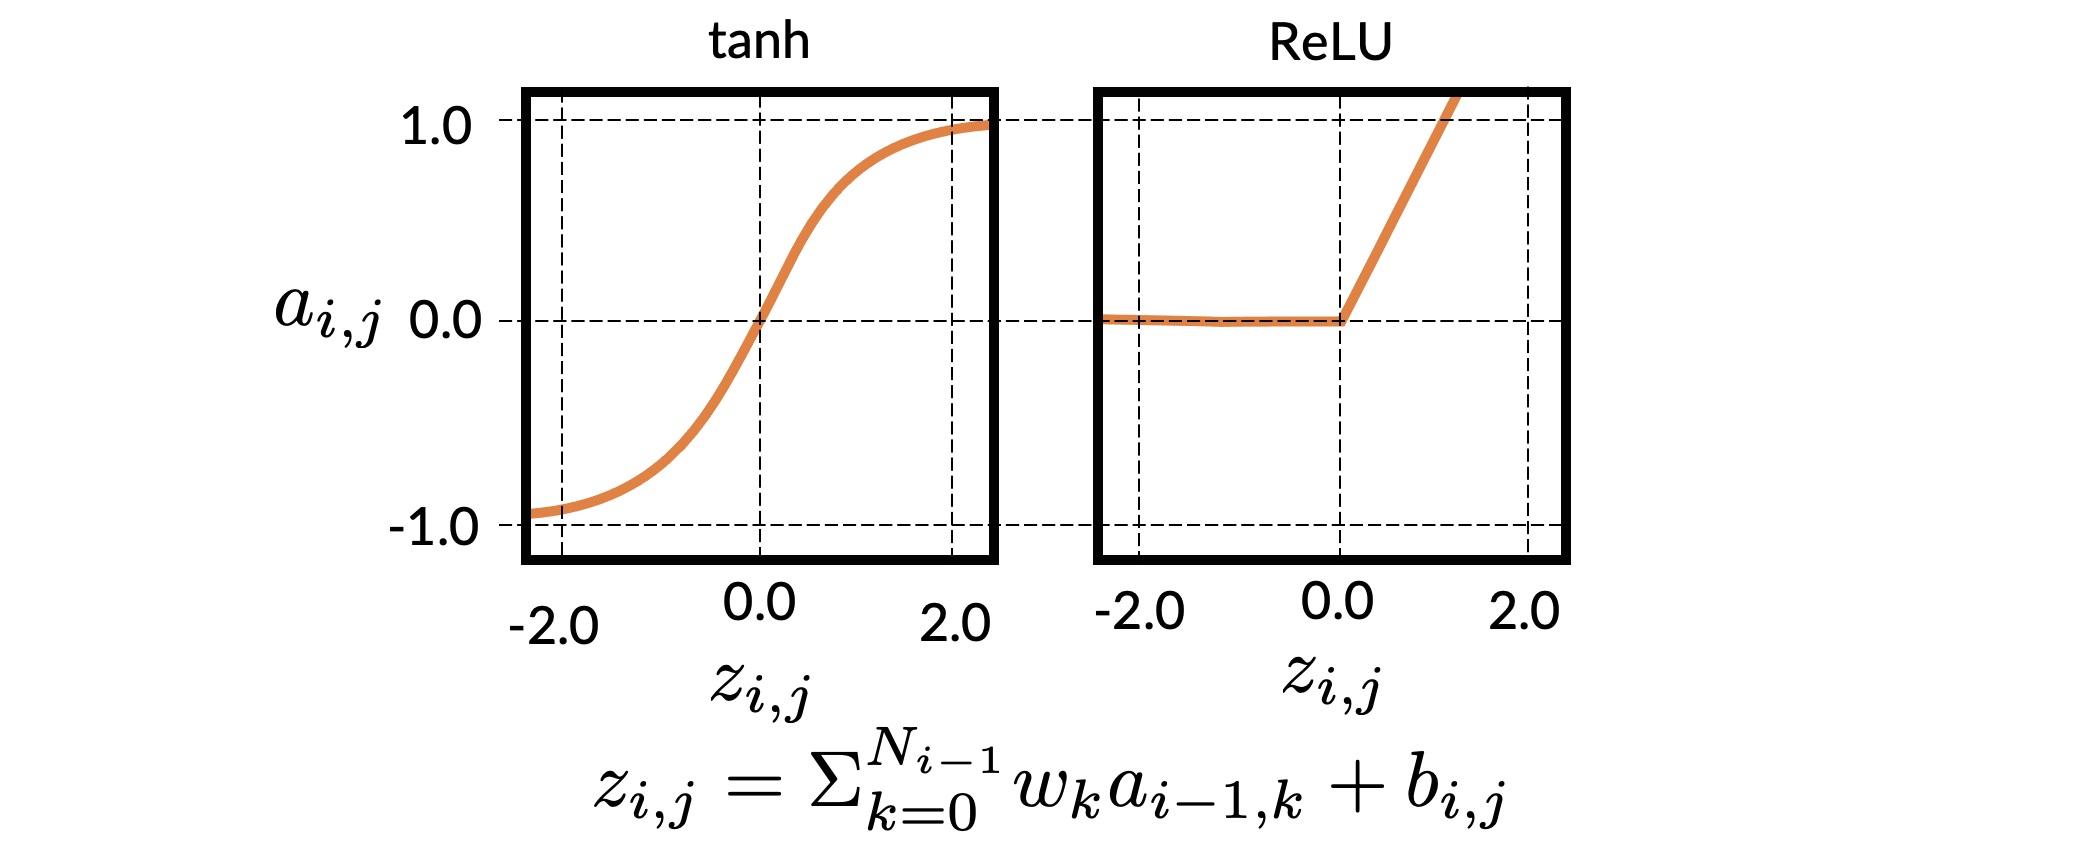

<font size=5><center>The activation function is a choice, there are many [options](https://www.analyticsvidhya.com/blog/2020/01/fundamentals-deep-learning-activation-functions-when-to-use-them/).

***

### B. _Poll_: Dimensionality of hidden layers

<font size=4> Here, we have 3 input features, eg. the dimensionality of our features is 3. What is the dimensionality of our third hidden layer?

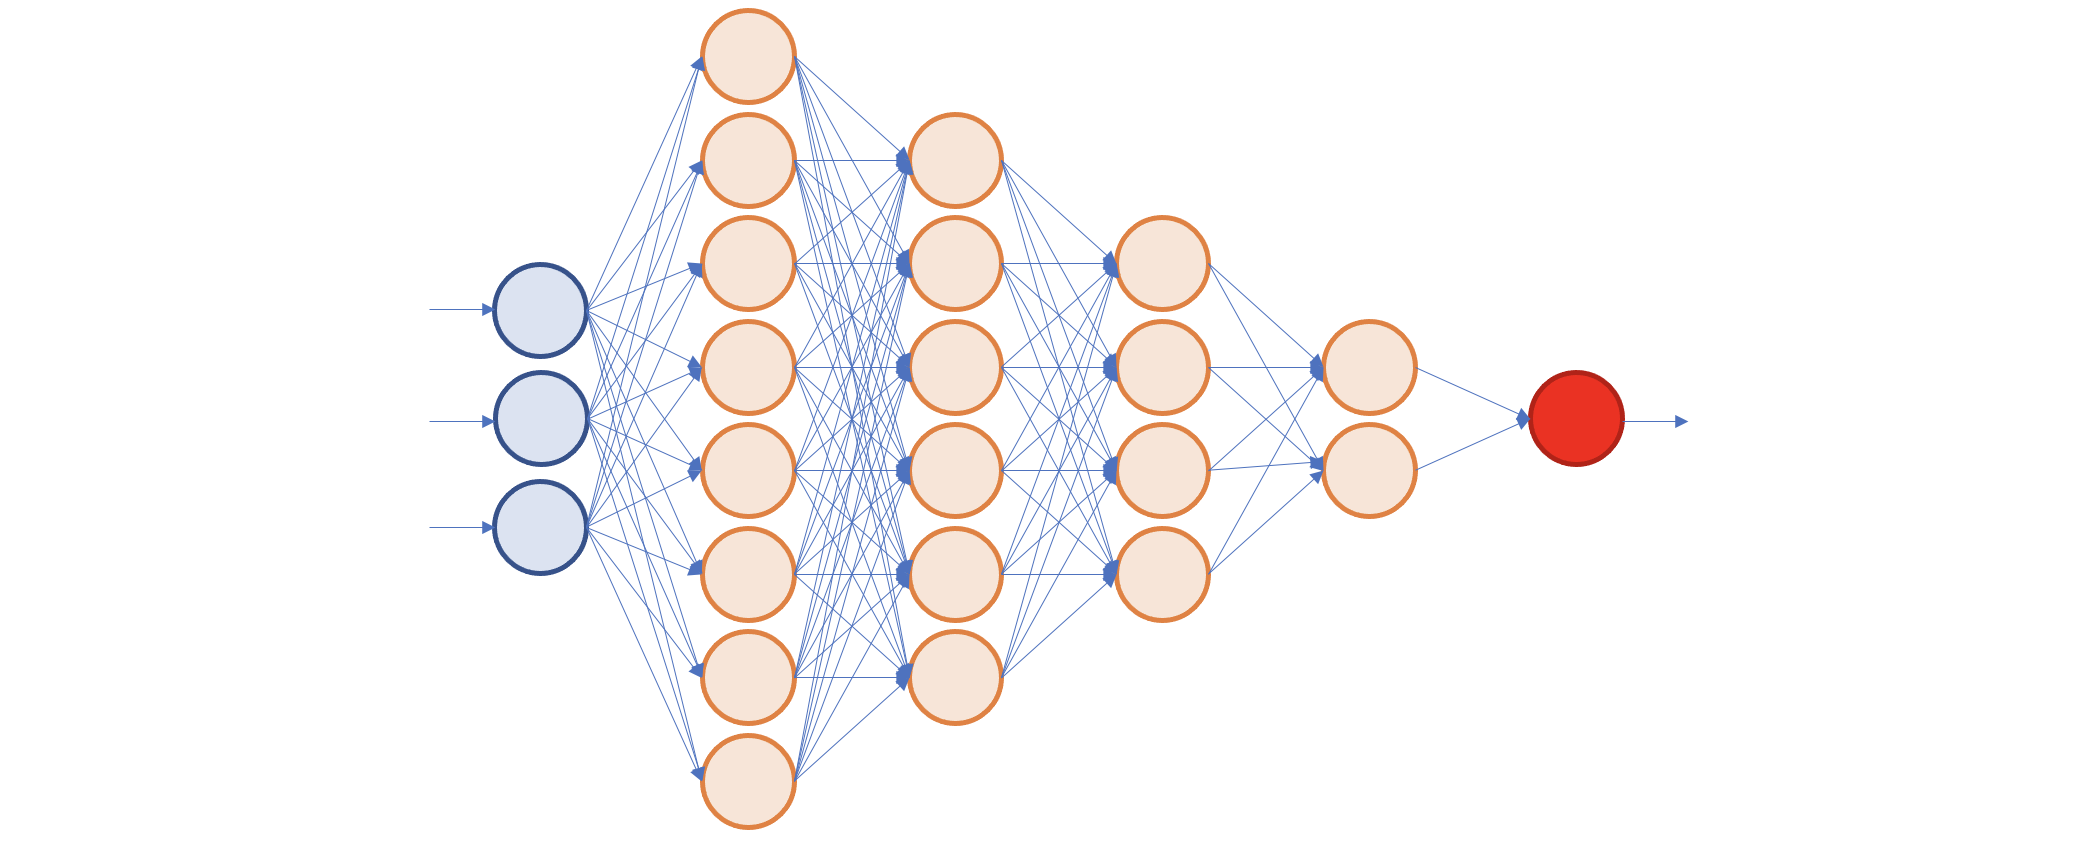

<font size=5><center>Each layer in the NN transforms the input into a new dimensional space.

***

<font size=5><center>The transformation of input to output then proceeds as follows:

1. <font size=4>__Every neuron__ in the first layer recieves __every feature__ and applies its own feature weights.
2. <font size=4>Each neuron sums the results, adds a bias, and passes the result though an activation function, producing __an activation for each neuron in the layer__. This vector of activations is often called the layer's hidden state, and has dimensions equal to the number of neurons in the kayer.
3. <font size=4>The second hidden layer recieves the first's activations, and __treats them exactly like the first treats features__.
4. <font size=4> __Repeat__ for each hidden layer.
5. <font size=4> The output layer works the same as the hidden layers, but __the number of neurons is equal to the dimensionality of the targets__, see the following table. Usually special activation functions are used on the output layer.

| Target | Output layer neuron count |
| ------ | ------------------------- |
| 1 regression target | 1 |
| binary classification | 1 |
| N-class classification (N>2) | N |
| N regression targets ("multitask model") | N |

***

### C. _Poll_: NN outputs

1. <font size=4> Consider the desired output of a classification problem (probability of each class). What characteristics of the activation function might we care about?(Min 0, Min -1, Max 0, Max 1, Sum 1, Sum 0)
    
2. <font size=4>For a regression task?

***

## 2. Backpropegation loss

### A. The loss surface

<font size=5><center>We know how the parameters transform the data from X input into target y prediction, __but how do we chose the parameter?__  Consider the mean squared error:

<font size=5>$$MSE = \frac{1}{M}\Sigma_i^M(y_i-\hat{y}_i)^2$$

<font size=5><center> For NNs, we have a very specific term called the __loss, that is just a chosen measure of error on the training data__.

<font size=4>For the sake of discussion, let's expand out model term:

<font size=5>$$\hat{y}_i = f(X_i;w_{0,0,0},...,w_{j,k,l}, b_{0,0}, ..., b_{j,k})$$

<font size=5><center> Our predictions are dependant on our parameters, __so our loss is dependant on our parameters__. This yield's a "loss surface"

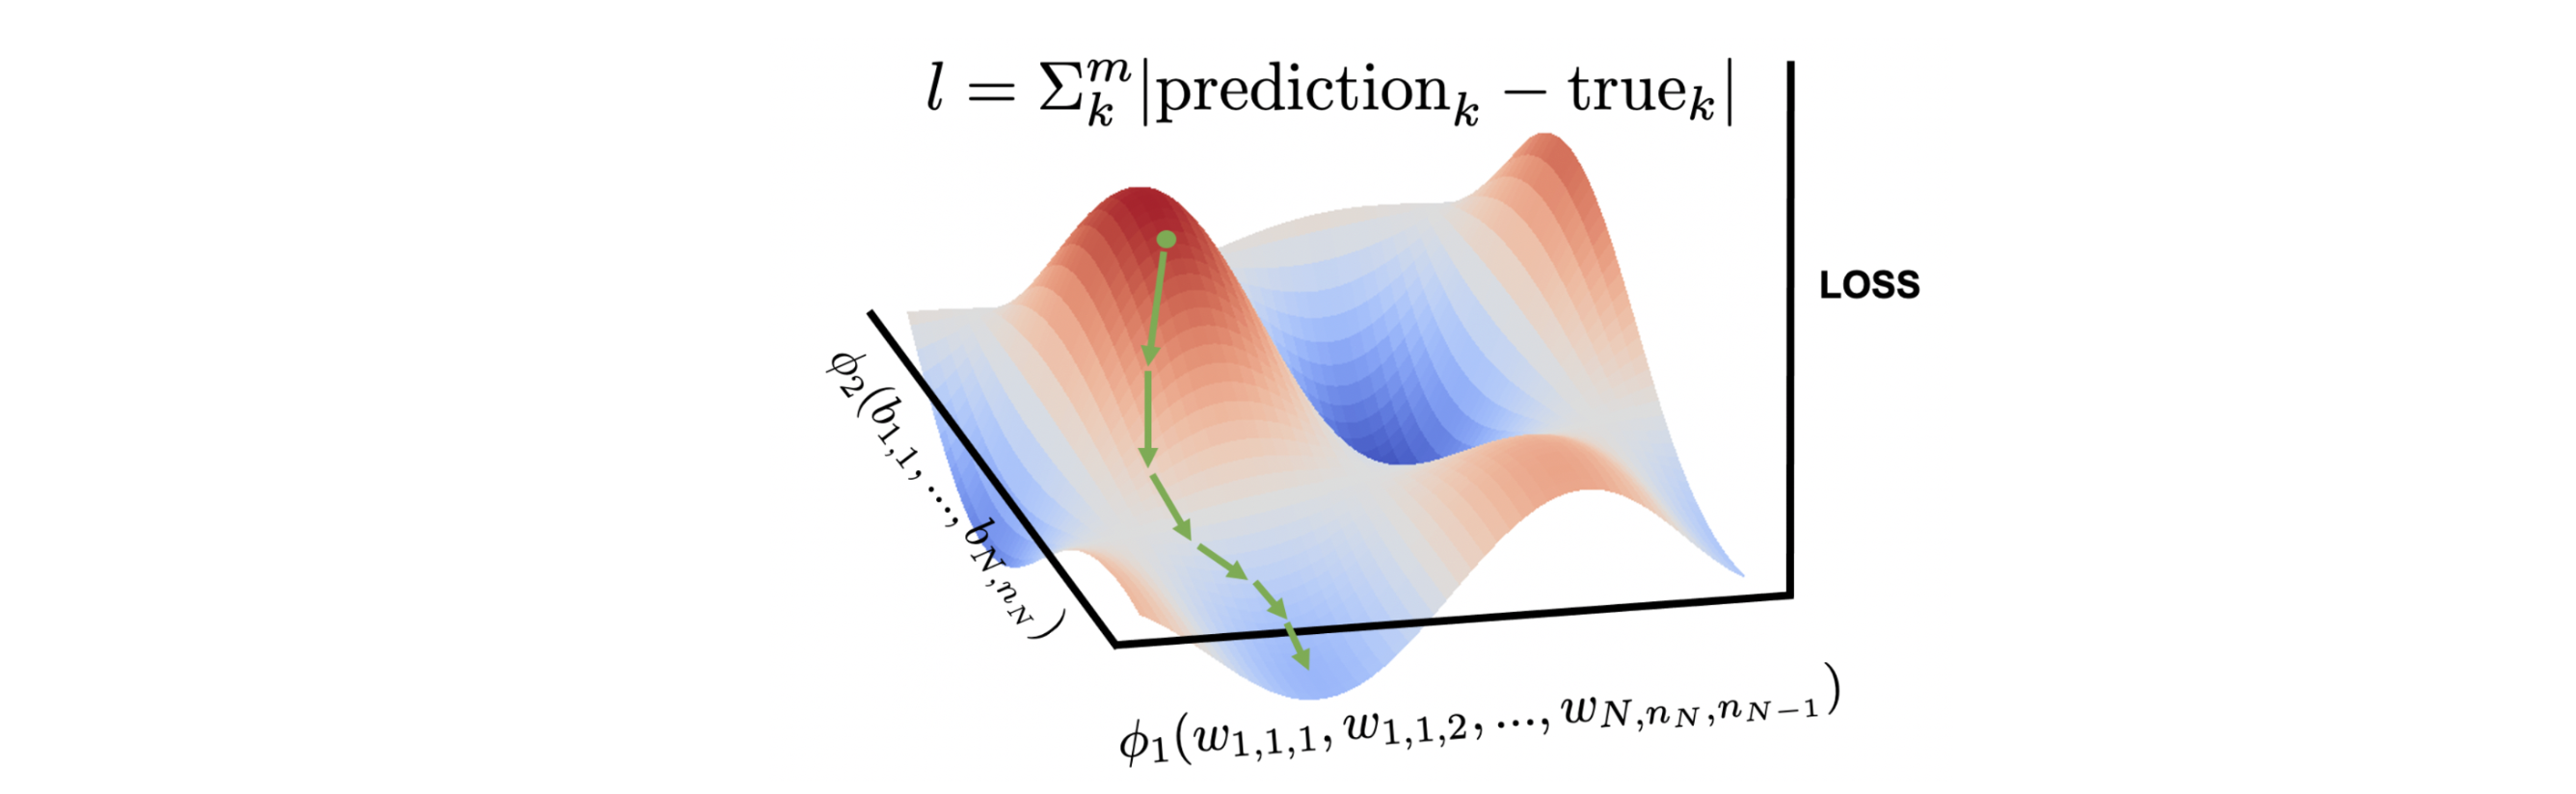

<font size=5><center> Our goal is to __change the parameters to minimize the loss__, and we can compute the loss for any set of parameters.

***

### B. Training epochs, monitoring training

<font size=5><center>__Critical__: While the optimum parameters (lowest loss) are __not__ analytical, the __derivative of the the loss with respect to the parameters *are*__. (As long as our activation functions are differentiable)

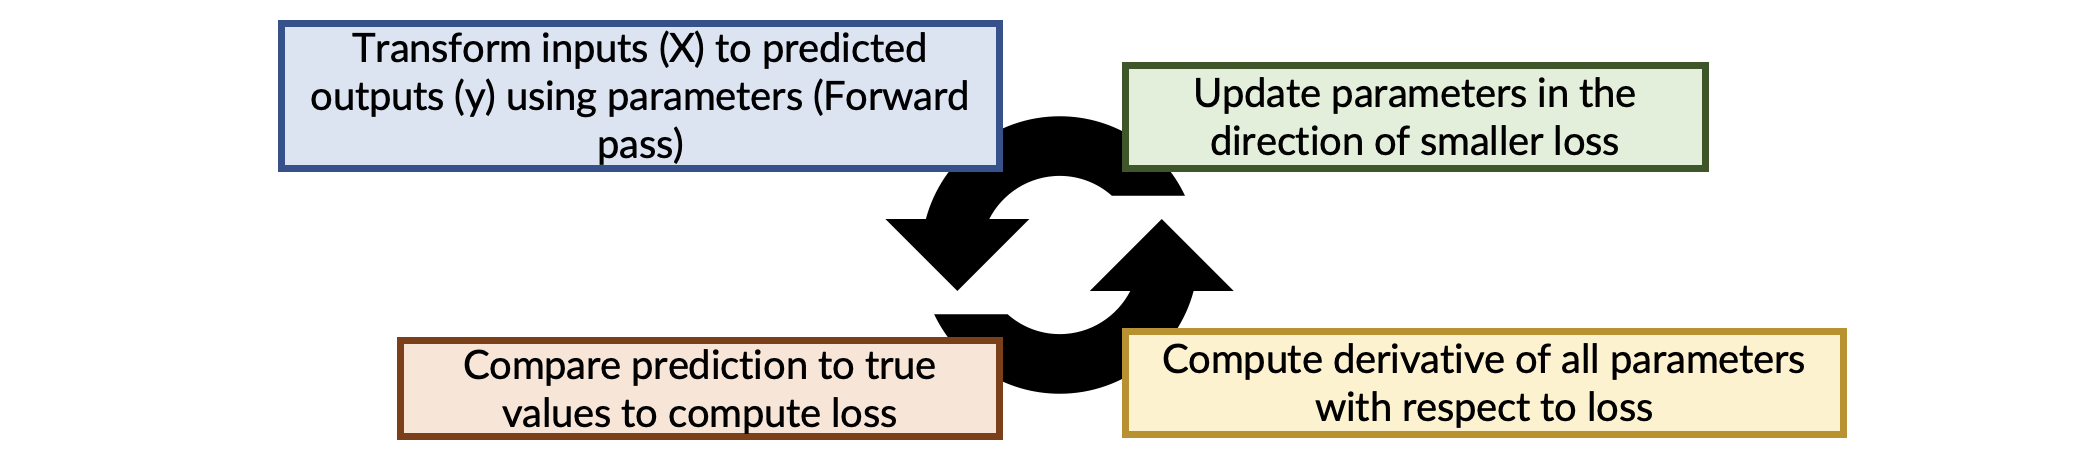

<font size=4>When we change the parameters in the direction of the gradient, we can take smaller, careful steps, or big ones. How much we move is dependant on what we call the __learning rate__:

<font size=5>$$p_{new} = p - \lambda \frac{dl}{dp}$$

<font size=4>$p$ is some parameter, $\lambda$ is the learning rate.

<font size=5><center>Every time we consider the whole training dataset to make parameter updates, this is called one __epoch__. Let me show you some pseudo code for the overall process:

In [2]:
"""
model = initialize_model()
learning_rate = 0.01

training_loss_history = []
validation_loss_history = []

for epoch in range(100):
    predictions = model.predict(train_X)
    train_loss = loss(train_y, predictions)
    val_loss = loss(val_y, model.predict(val_X))
    
    gradients = model.compute_gradients(train_loss)
    model.update_parameters(gradients, learning rate)
    
    training_loss_history.append(train_loss)
    validation_loss_history.append(val_loss)
"""

'\nmodel = initialize_model()\nlearning_rate = 0.01\n\ntraining_loss_history = []\nvalidation_loss_history = []\n\nfor epoch in range(100):\n    predictions = model.predict(train_X)\n    train_loss = loss(train_y, predictions)\n    val_loss = loss(val_y, model.predict(val_X))\n    \n    gradients = model.compute_gradients(train_loss)\n    model.update_parameters(gradients, learning rate)\n    \n    training_loss_history.append(train_loss)\n    validation_loss_history.append(val_loss)\n'

***

### C. _Poll_: Large vs small learning rate

<font size=4>What could go wrong if the learning rate is "too large"? What about "too small"?

***

### D. A worked example using very nonlinear features

<font size=5><center>Throughout the rest of the notebook I will point out some <span style="color:green">pros</span> of NNs and some <span style="color:orange">cons</span>...

<font size=4>Here we load the HCEPDB data, and we will regress the energy gap

In [3]:
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(10000, random_state=1)

<font size=5><center><span style="color:green">NNs can leverage very large amounts of data because the can be made infinitely complex, HCEPDB is quite a large dataset, so an NN may be a good choice.

<font size=4>Let's extract the data

In [4]:
smiles = df['SMILES_str']

<font size=4>We will use rdkit to extract a new type of feature we haven't seen for molecules before called "[fingerprints](https://medium.com/@hacertilbec/introduction-to-cheminformatics-circular-fingerprints-f557cdc77492)." *If you are not going to be working to apply ML directly to molecular structure eg SMILES, don't worry too much about this* but basically fingerprints count up bonding patters in the structure like.

In [5]:
def get_fingerprint(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol == None:
        return None
    fp = rdkit.Chem.RDKFingerprint(mol)
    npfp = np.unpackbits(np.frombuffer(
        rdkit.DataStructs.BitVectToBinaryText(fp), dtype=np.uint8), bitorder='little')
    return npfp

In [6]:
fingerprints = smiles.apply(get_fingerprint)

[13:07:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10 11 12 13 15 16 17 18 19 20 21
[13:07:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19 20 21 22
[13:07:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9 10 12 13 14 15 16 17 18 19 20 21 22 24 25
[13:07:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25
[13:07:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 9 10 11 12 14 15 16 17 18 20 21 22
[13:07:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18
[13:07:55] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10 11 12 13 14 15 16 17 18
[13:07:55] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
[13:07:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 21 22
[13:07:57] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 

<font size=4>Did we fail to compute features for any?

In [7]:
fingerprints.isna().mean()

0.0039

<font size=4>yes, for 0.3%. Drop them and get X and y

In [8]:
df['fps'] = fingerprints
print(f"Original amount of examples: {len(df)}")

Original amount of examples: 10000


In [9]:
df = df[~df['fps'].isna()]
print(f"Examples with successfully computed features: {len(df)}")

Examples with successfully computed features: 9961


In [10]:
X = np.vstack(df['fps'].values)
y = df['e_gap_alpha'].values.reshape(-1,1)

In [11]:
print(f"Shape of X: {X.shape}")

Shape of X: (9961, 2048)


<font size=4>The fingerprint has a lot of features... what do they look like?

In [12]:
X[0,:]

array([1, 1, 0, ..., 0, 1, 1], dtype=uint8)

<font size=4>So they are just zeros and ones... these features __are no longer physically interpretable quantities like descriptors eg. molar mass__.

<font size=5><center><span style="color:green">NNs are very good at working with complex, highly nonlinear, non-human readable features.

<font size=4>For giggles, lets PCA this and see how much we can reduce the dimensions...

In [13]:
pca = sklearn.decomposition.PCA(100)
pca.fit(X)

PCA(n_components=100)

In [14]:
np.cumsum(pca.explained_variance_ratio_)[-1]

0.6601089679523623

<font size=4>Even with __100 components we only explain 66% if the variance__. This indicates that the features are __not even close__ to linearly related to eachother and we have lots of them, so our NN (very non linear) is a good choice for this kind of feature.

***

<font size=4>Typical preprocessing

In [15]:
dev_X, test_X, dev_y, test_y = sklearn.model_selection.train_test_split(X, y, test_size=0.15, random_state=42)
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(dev_X, dev_y, test_size=0.15, random_state=42)

In [16]:
np.unique(dev_X)

array([0, 1], dtype=uint8)

<font size=4>Data are nominal, eg. bits. No need for standardization

***

<font size=4>Train the model with tensorflow [Keras](https://keras.io/). [PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) is another popular library.

In [17]:
def build_basic_dnn():
    """Create a simple dense neural network with 3 hidden layers of 3, 4, 5 neurons
    and an output layer.
    
    Returns:
        model (ks.model): 
            the defined keras model
    """
    ## initialize the model
    # "sequential" is the most basic type of NN, the one we introduced, where
    # information flows from left to right sequentially
    model = ks.Sequential() 
    
    ## Add the three hidden layers of 92, 64, 12 neurons each
    model.add(
        ks.layers.Dense(32, activation='tanh') # Remember the tanh activation function?
    )
    
    model.add(
        ks.layers.Dense(24, activation='tanh')
    )
    
    model.add(
        ks.layers.Dense(12, activation='tanh')
    )
    
    ## add the output layer
    #. it is just 1 neuron
    #. Notice the activation function?
    model.add(ks.layers.Dense(1))
    
    ## compile the model
    #. using MSE as the loss function
    model.compile(loss = 'MSE')
    
    #. tell the model how many features to expect
    model.build(input_shape=train_X.shape)
    
    ## return the compiled model
    return model

<font size=4>*Note* the MSE loss and the linear activation of the output neuron are valid for regression. For classification, one has to consider another loss and activation, like [log loss](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) and [softmax](https://keras.io/api/layers/activation_layers/softmax/).

In [18]:
model = build_basic_dnn()

2023-01-11 13:08:15.111935: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


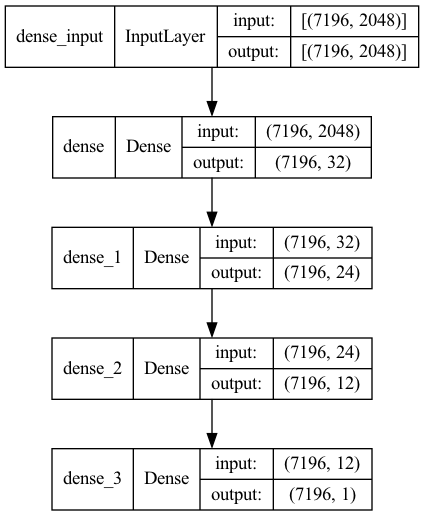

In [19]:
keras.utils.vis_utils.plot_model(model, show_shapes=True)

<font size=5><center> __At the start, the NN has random parameters__. It can still predict, it just won't be predictive at all... 

In [20]:
train_mean = train_y.mean()
print(f"Null model validation MSE: {sklearn.metrics.mean_squared_error(val_y, np.ones(val_y.shape)*train_mean)}")

Null model validation MSE: 0.15271280378716917


In [21]:
init_model_predictions = model.predict(val_X)
print(f"Initial model validation MSE: {sklearn.metrics.mean_squared_error(val_y, init_model_predictions)}")

Initial model validation MSE: 8.543257271484157


<font size=4>The model is basically just randomly predicting, so it is worse than even the null model. Let's train it for a few iterations

In [22]:
## and train the model with the fit method
#. specify 5 epochs, or 5 iterations through the dataset
#. Increase verbosity so that we can observe everything that happens
#. store the history of training
history = model.fit(
    train_X, train_y, epochs=5, batch_size=len(train_X), verbose=2)

Epoch 1/5
1/1 - 0s - loss: 8.5976 - 329ms/epoch - 329ms/step
Epoch 2/5
1/1 - 0s - loss: 0.3988 - 36ms/epoch - 36ms/step
Epoch 3/5
1/1 - 0s - loss: 0.3053 - 38ms/epoch - 38ms/step
Epoch 4/5
1/1 - 0s - loss: 0.2532 - 40ms/epoch - 40ms/step
Epoch 5/5
1/1 - 0s - loss: 0.2238 - 36ms/epoch - 36ms/step


In [23]:
trained_model_predictions = model.predict(val_X)
print(f"Trained model validation MSE: {sklearn.metrics.mean_squared_error(val_y, trained_model_predictions)}")

Trained model validation MSE: 0.20271024849755326


Text(0, 0.5, 'training loss')

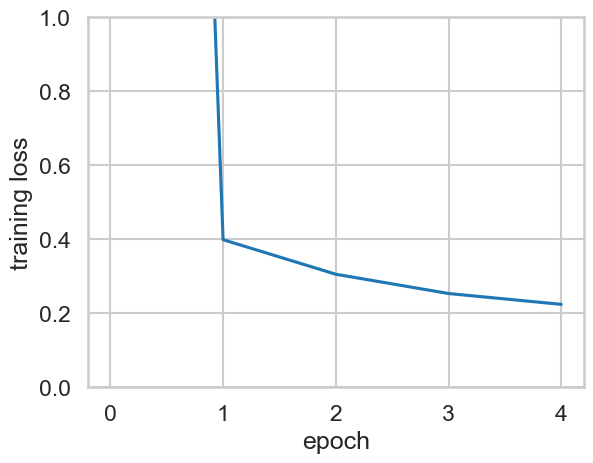

In [24]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylim(0,1)
ax.set_ylabel('training loss')

<font size=4>It is not good enough clearly! We have to do more parameter updates...

***

### E. Batching

<font size=4>What if we considered small samples of data at a time? This is called batching.

<font size=5><center>When we batch, we assume that the loss surface for the batch is approximately the overall loss surface:

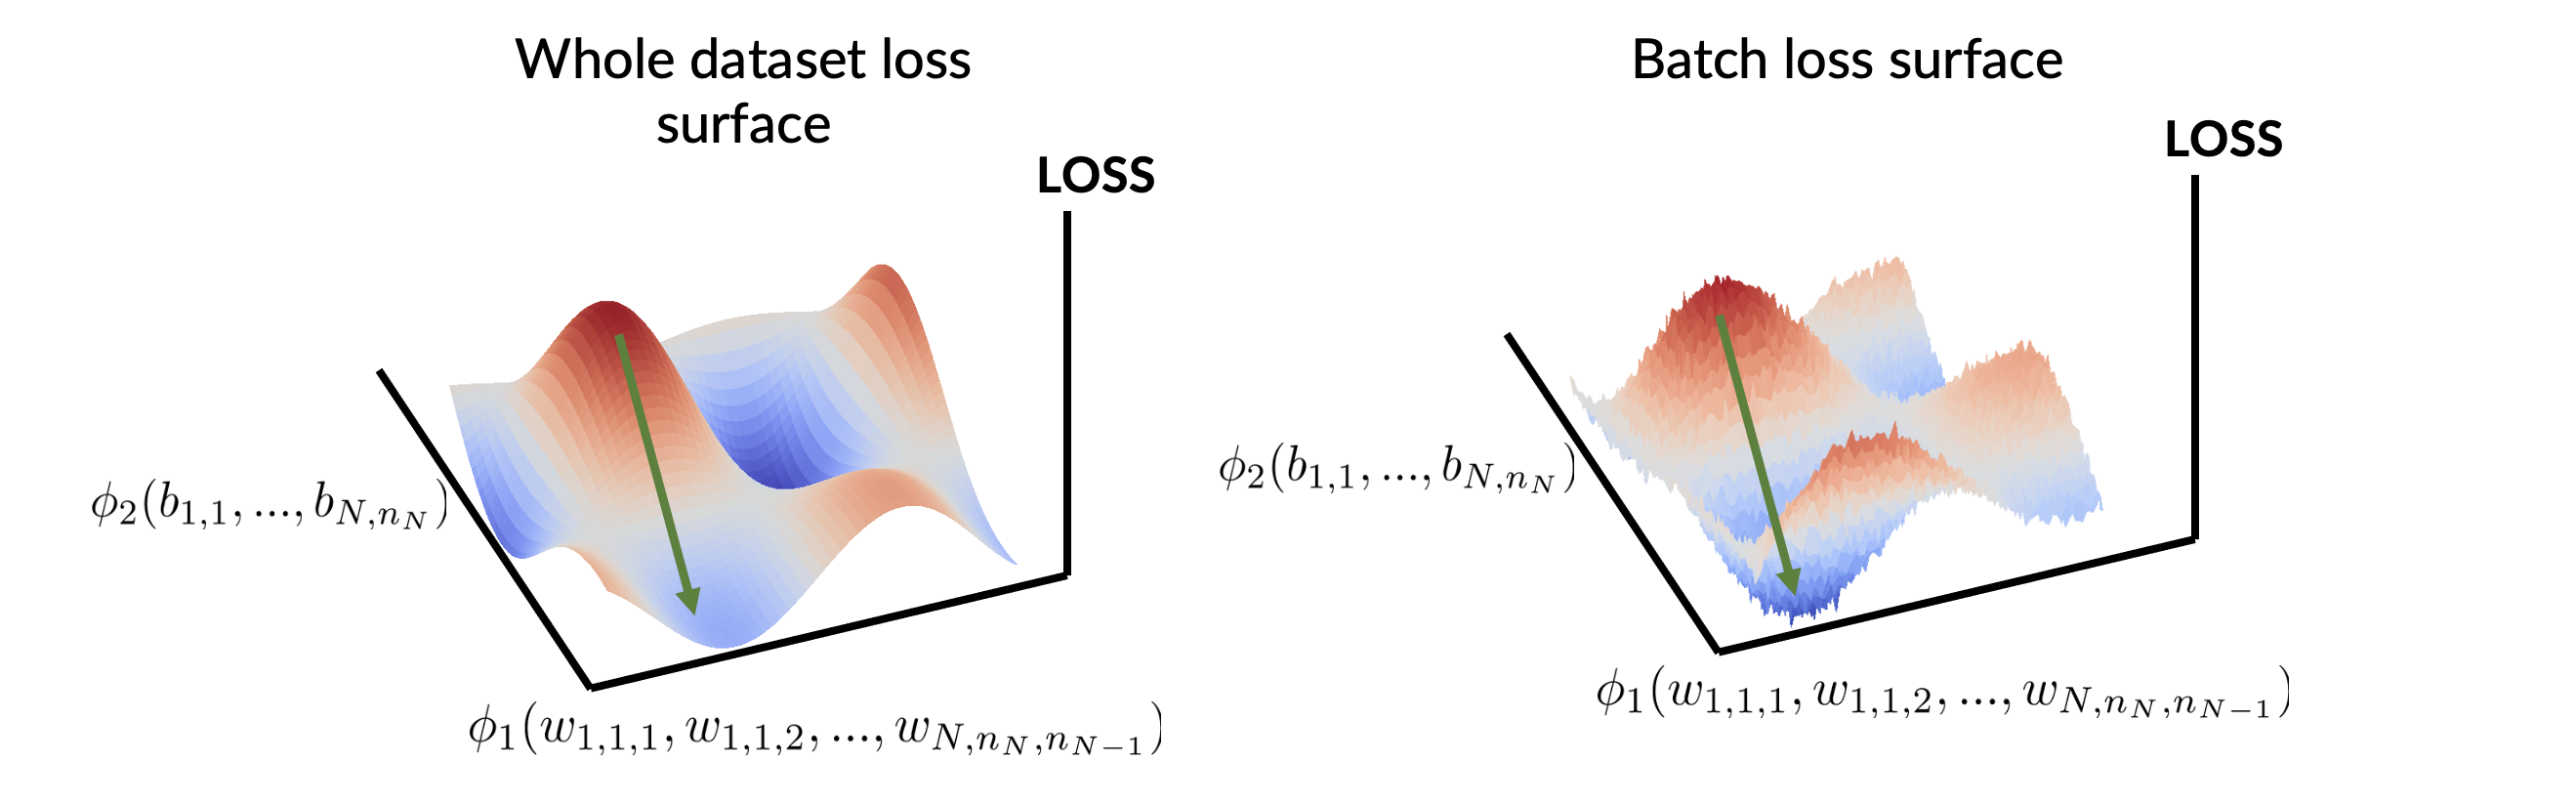

<font size=5><center>If we have a dataset of size $m$ and batch size $m_b$ then we can make $\frac{m_b}{m}$ parameter updates per epoch.

In [25]:
model = build_basic_dnn()

In [26]:
## here the batch size is smaller than the total dataset
history = model.fit(
    train_X, train_y, epochs=5, batch_size=32, verbose=2)

Epoch 1/5
225/225 - 1s - loss: 0.1061 - 605ms/epoch - 3ms/step
Epoch 2/5
225/225 - 0s - loss: 0.0531 - 320ms/epoch - 1ms/step
Epoch 3/5
225/225 - 0s - loss: 0.0428 - 331ms/epoch - 1ms/step
Epoch 4/5
225/225 - 0s - loss: 0.0389 - 330ms/epoch - 1ms/step
Epoch 5/5
225/225 - 0s - loss: 0.0339 - 317ms/epoch - 1ms/step


Text(0, 0.5, 'training loss')

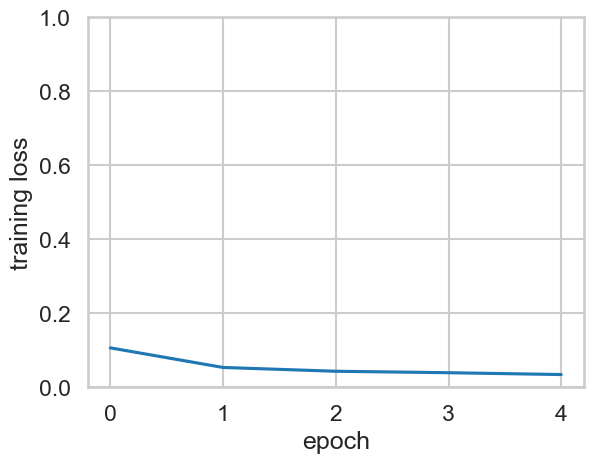

In [27]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.set_xlabel('epoch')
ax.set_ylim(0,1)
ax.set_ylabel('training loss')

<font size=4>Our training loss is now an order of magnitude lower - it can learn faster because of our assumption that the batch loss surface is similar to the overall loss surface.

<font size=5><center><span style="color:orange"> Batching helps us reduce the cost of training NNs, but even still the cost scales with data size and network complexity, which are exactly the same reasons that NNs might be useful.

***

### F. _Exercise_: Identify overfitting.

<font size=5><center><span style='color:orange'>Tendancy to overfit is one of the most aggregious disadvantages of NNs

<font size=4> Recall that if the validation/test error is much worse than the training error, we may have an overfit model. E.g. the model memorizes the training data and can no longer extrapolate to new data. __Retrain a new NN for 200 epochs, and this time also track the loss on the validation dataset. Show the training and validation loss over epochs__. *Hint* check the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit) for the `fit` method of the model.

> <span style='color:red'> remove for lec

In [28]:
model = build_basic_dnn()

In [29]:
## here the batch size is smaller than the total dataset
history = model.fit(
    train_X, train_y, validation_data=(val_X, val_y), epochs=200, batch_size=32, verbose=2)

Epoch 1/200
225/225 - 1s - loss: 0.0996 - val_loss: 0.0917 - 731ms/epoch - 3ms/step
Epoch 2/200
225/225 - 0s - loss: 0.0543 - val_loss: 0.0646 - 370ms/epoch - 2ms/step
Epoch 3/200
225/225 - 0s - loss: 0.0437 - val_loss: 0.0520 - 360ms/epoch - 2ms/step
Epoch 4/200
225/225 - 0s - loss: 0.0375 - val_loss: 0.0343 - 373ms/epoch - 2ms/step
Epoch 5/200
225/225 - 0s - loss: 0.0346 - val_loss: 0.0305 - 365ms/epoch - 2ms/step
Epoch 6/200
225/225 - 0s - loss: 0.0313 - val_loss: 0.0314 - 366ms/epoch - 2ms/step
Epoch 7/200
225/225 - 0s - loss: 0.0283 - val_loss: 0.0274 - 372ms/epoch - 2ms/step
Epoch 8/200
225/225 - 0s - loss: 0.0264 - val_loss: 0.0498 - 373ms/epoch - 2ms/step
Epoch 9/200
225/225 - 0s - loss: 0.0254 - val_loss: 0.0280 - 368ms/epoch - 2ms/step
Epoch 10/200
225/225 - 0s - loss: 0.0236 - val_loss: 0.0290 - 369ms/epoch - 2ms/step
Epoch 11/200
225/225 - 0s - loss: 0.0228 - val_loss: 0.0245 - 368ms/epoch - 2ms/step
Epoch 12/200
225/225 - 0s - loss: 0.0214 - val_loss: 0.0611 - 369ms/epoch 

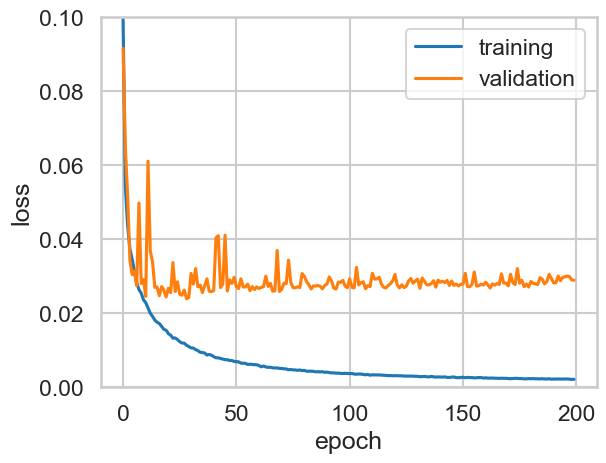

In [30]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(0,.1)
ax.legend()

<font size=4>Training quickly does not benefit the model's ability to generalize, so this mode is overfit.

***

### 3. Some neural network hyperparameters

<font size=5><center><span style='color:orange'>NNs have a ridiculous number of hyperparameters, poor choices can mean the difference between a good model and a useless one.

***

### A. Network parameters

#### Layer sizes

<font size=4>The complexity of the model is directly tied with the number of neurons and number of layers. If you add a new layer of $N$ neurons after a layer of $M$ neurons, you added $N*(M+1)$ parameters to the model, __increasing the complexity and the cost.__

#### Neurons

<font size=4>__The choice of activation functions__ are crucial and can make a big difference in model performance and cost. Consider the following:

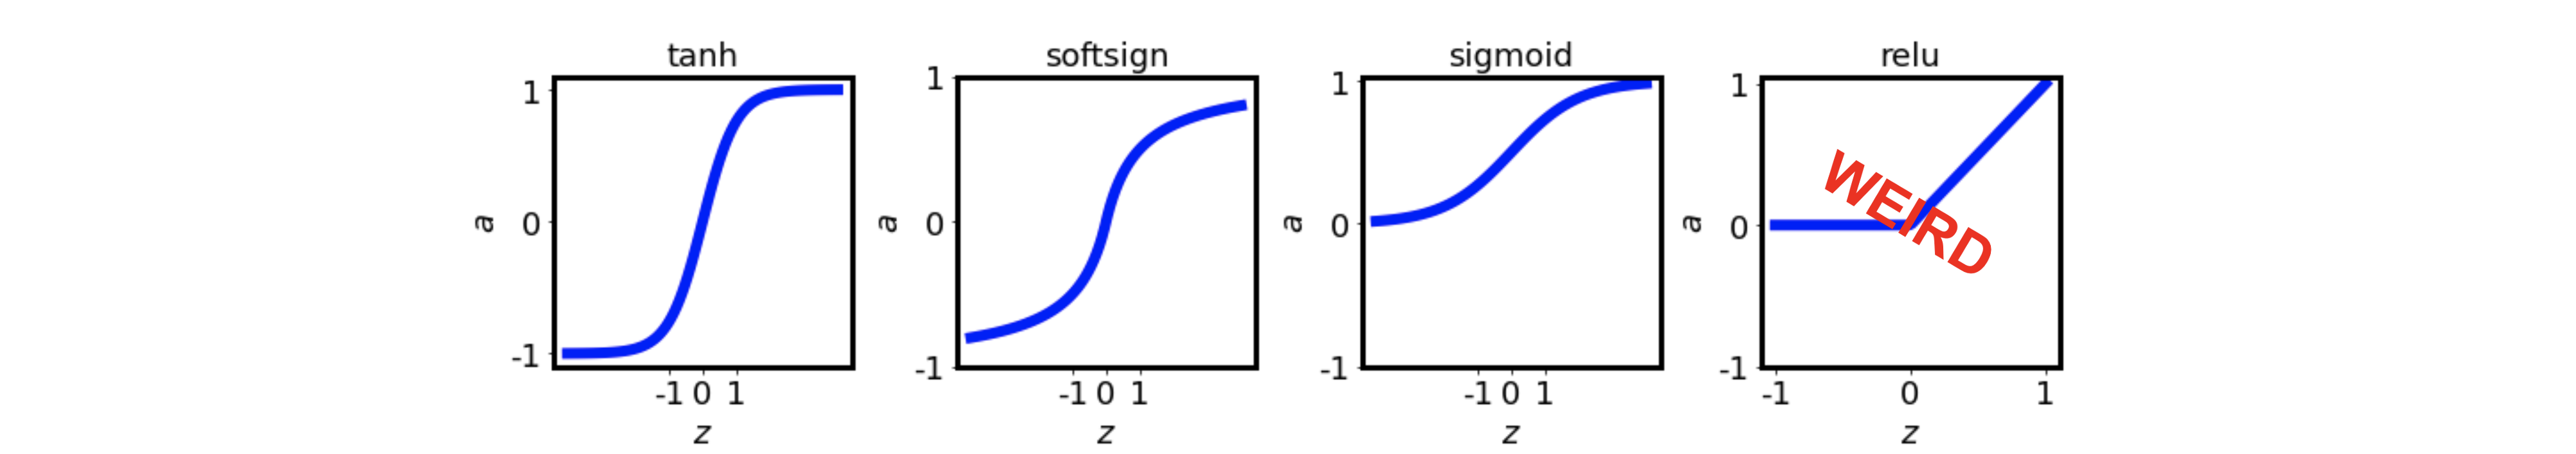

<font size=4>Two points:

1. <font size=4>What is the cost of computing the gradient? If it is a more difficult mathematical expression it takes longer to compute the gradient, which is the primary cost of training NNs. __Note ReLU is frequently used for this reason.__
    
2. <font size=4>What is the gradient $\frac{da}{dz}$ at different values of $z$? __If it is small, then the parameters will be updated slower__.

<font size=5><center>We ideally want to make choices such that the values of activations in the network are close to 0, so that it can learn faster.

<font size=4>We can pass the `activation` kwarg to `Dense`

In [31]:
ks.layers.Dense(5, activation='relu')

***

### B. _Poll_: Active region

<font size=4>If the __magnitude of parameters in a neuron are large__ what will the value of the activation be?
    
1. Small (close to zero)
2. Large (far from 0)
3. Negative
4. Positive

***

<font size=4>It is for this reason that __weight initialization__ impacts model performance. A common initialization strategy is to randomize them using a Normal distribution. We can change the initialization of parameters using the `kernel_initializer` and `bias_initializer` kwargs to the `Dense` layer.

In [32]:
ks.layers.Dense(5, kernel_initializer='uniform', bias_initializer='zeros')

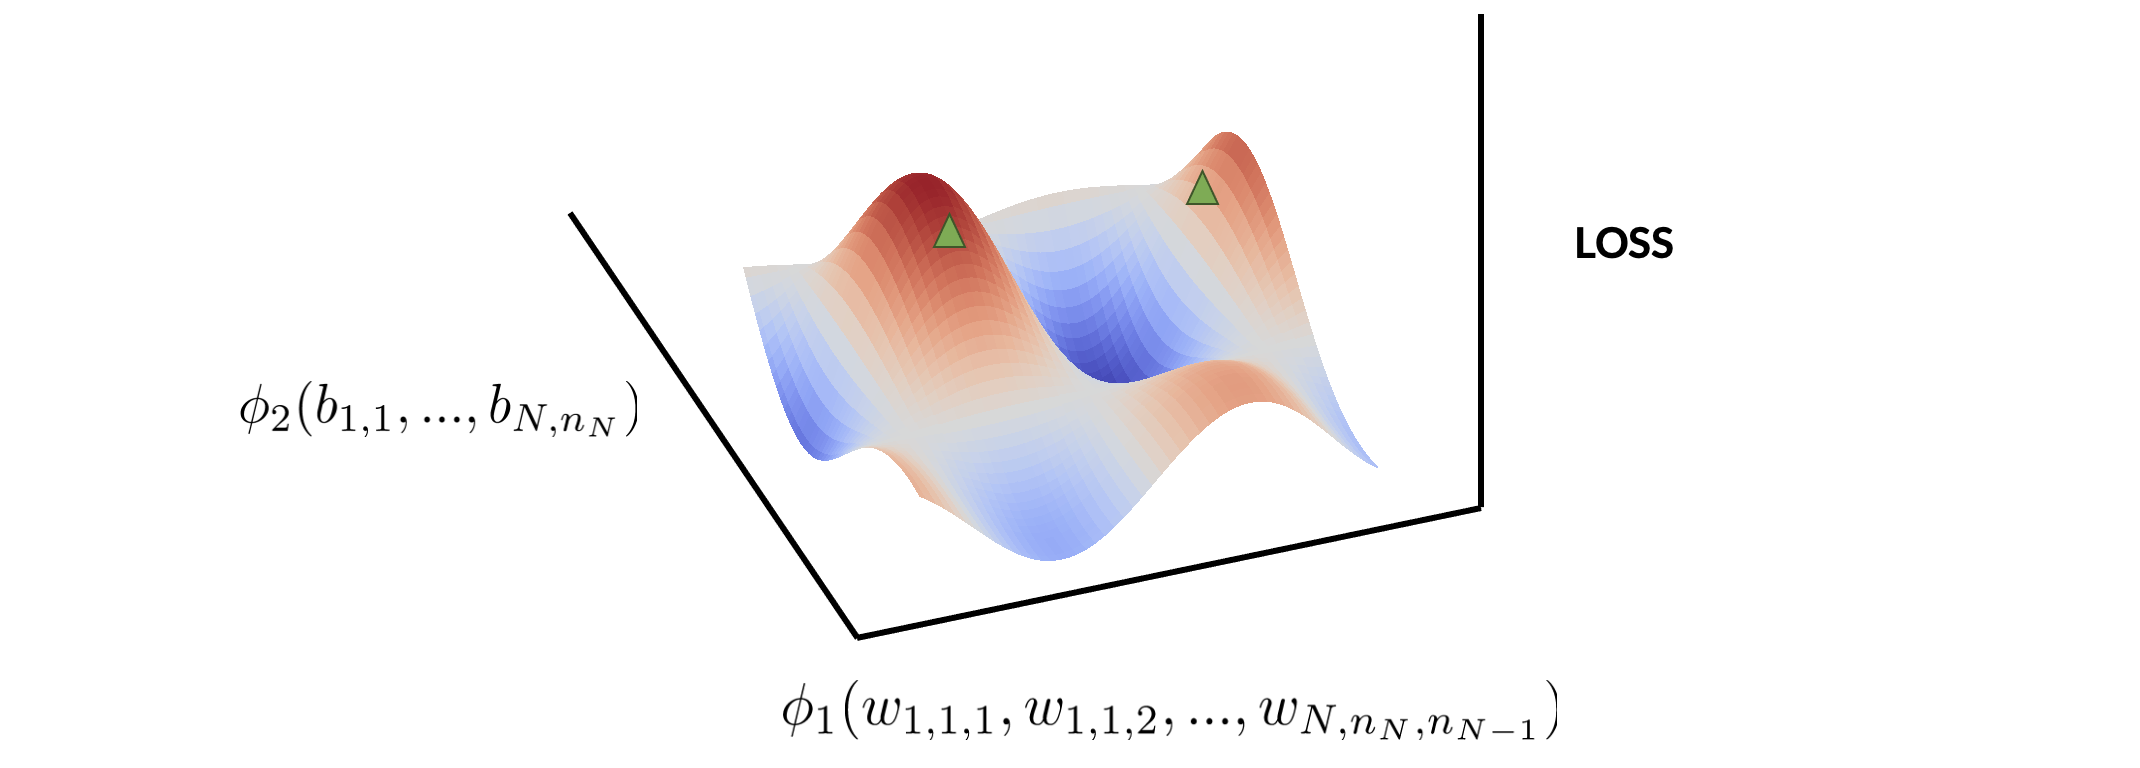

***

### C. Preprocessing hyperparameters

<font size=5><center>__The features you use are hyperparameters!__ But also our steps for processing the data affect the performance and cost.

<font size=4>We want the data distribution to be within the active region

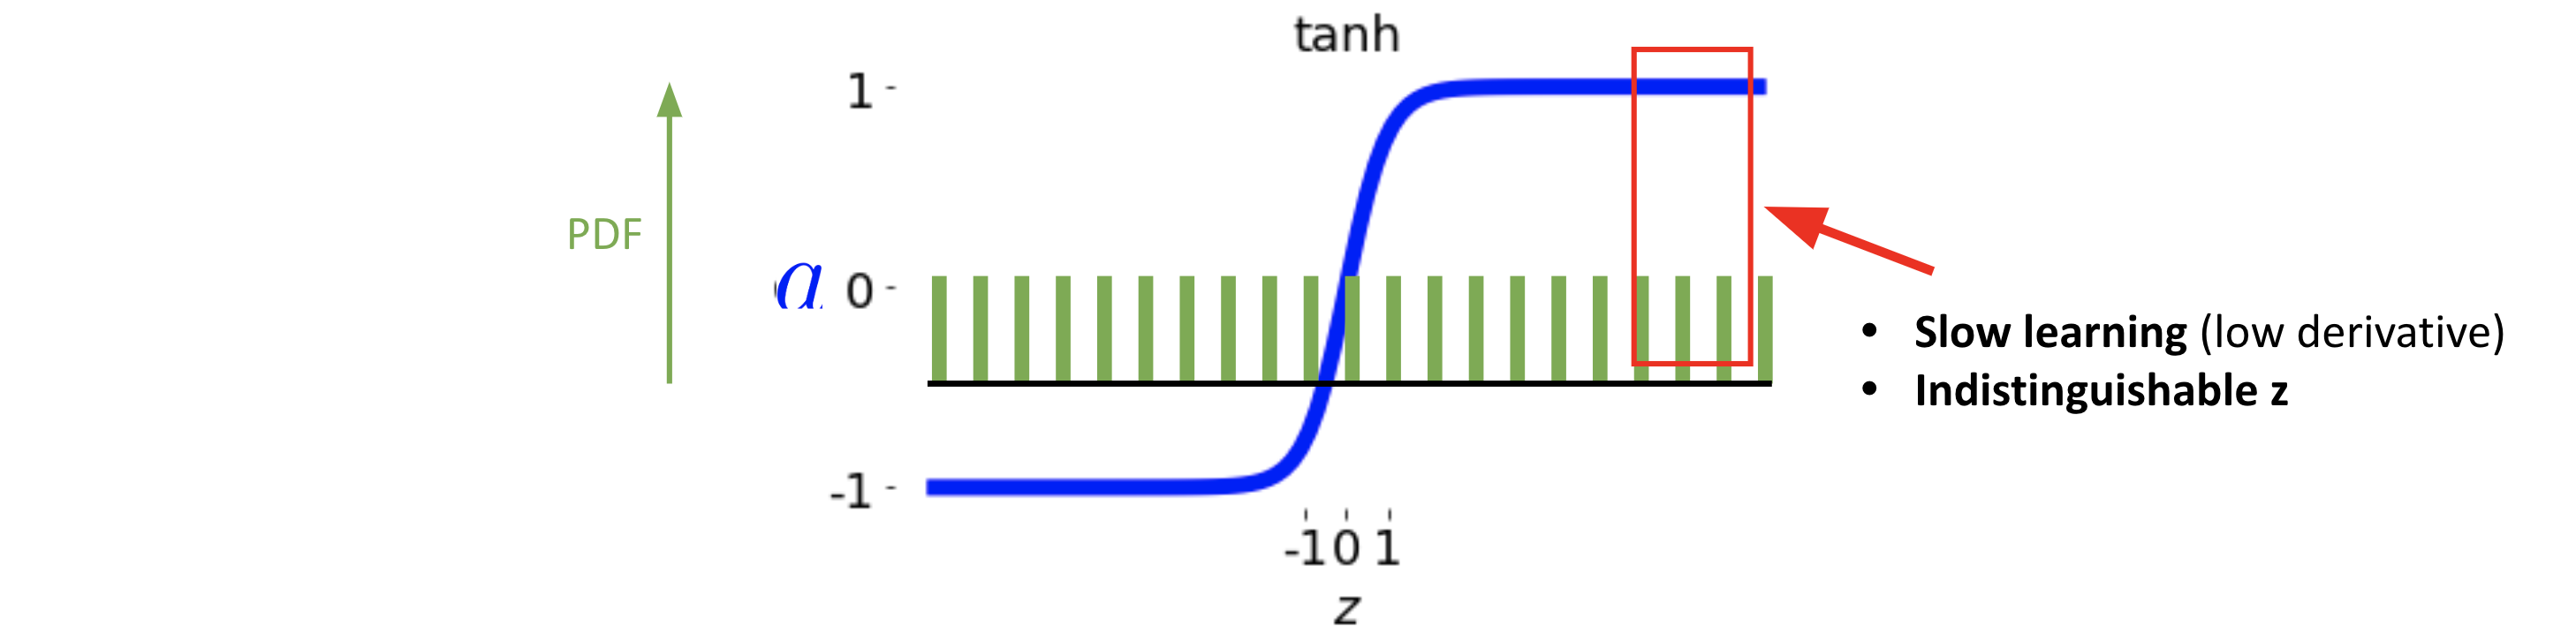

<font size=4>Standardization can help

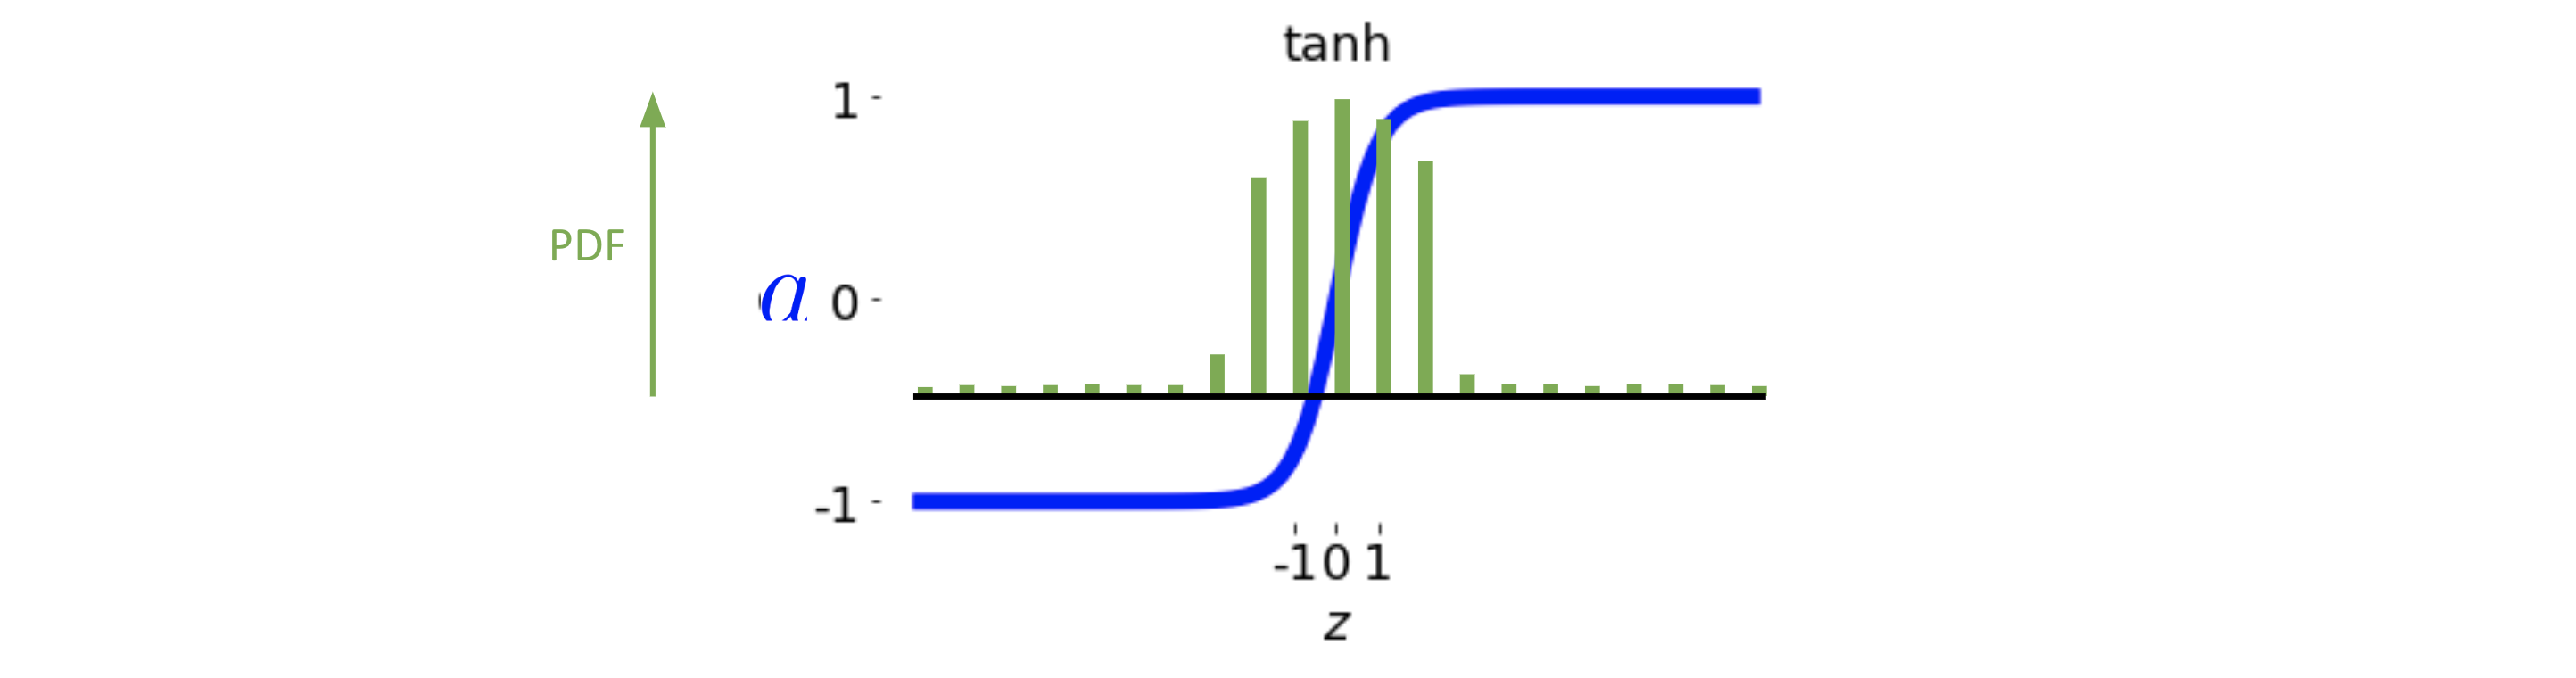

<font size=4>[MinMax]() scaling ensures all data is in the active region, and is great when the data is close to uniformly distributed or takes on nominal values.
    
<font size=4>[Standard]() scaling is much better when the data is already somewhat gaussian __or has large outliers__.

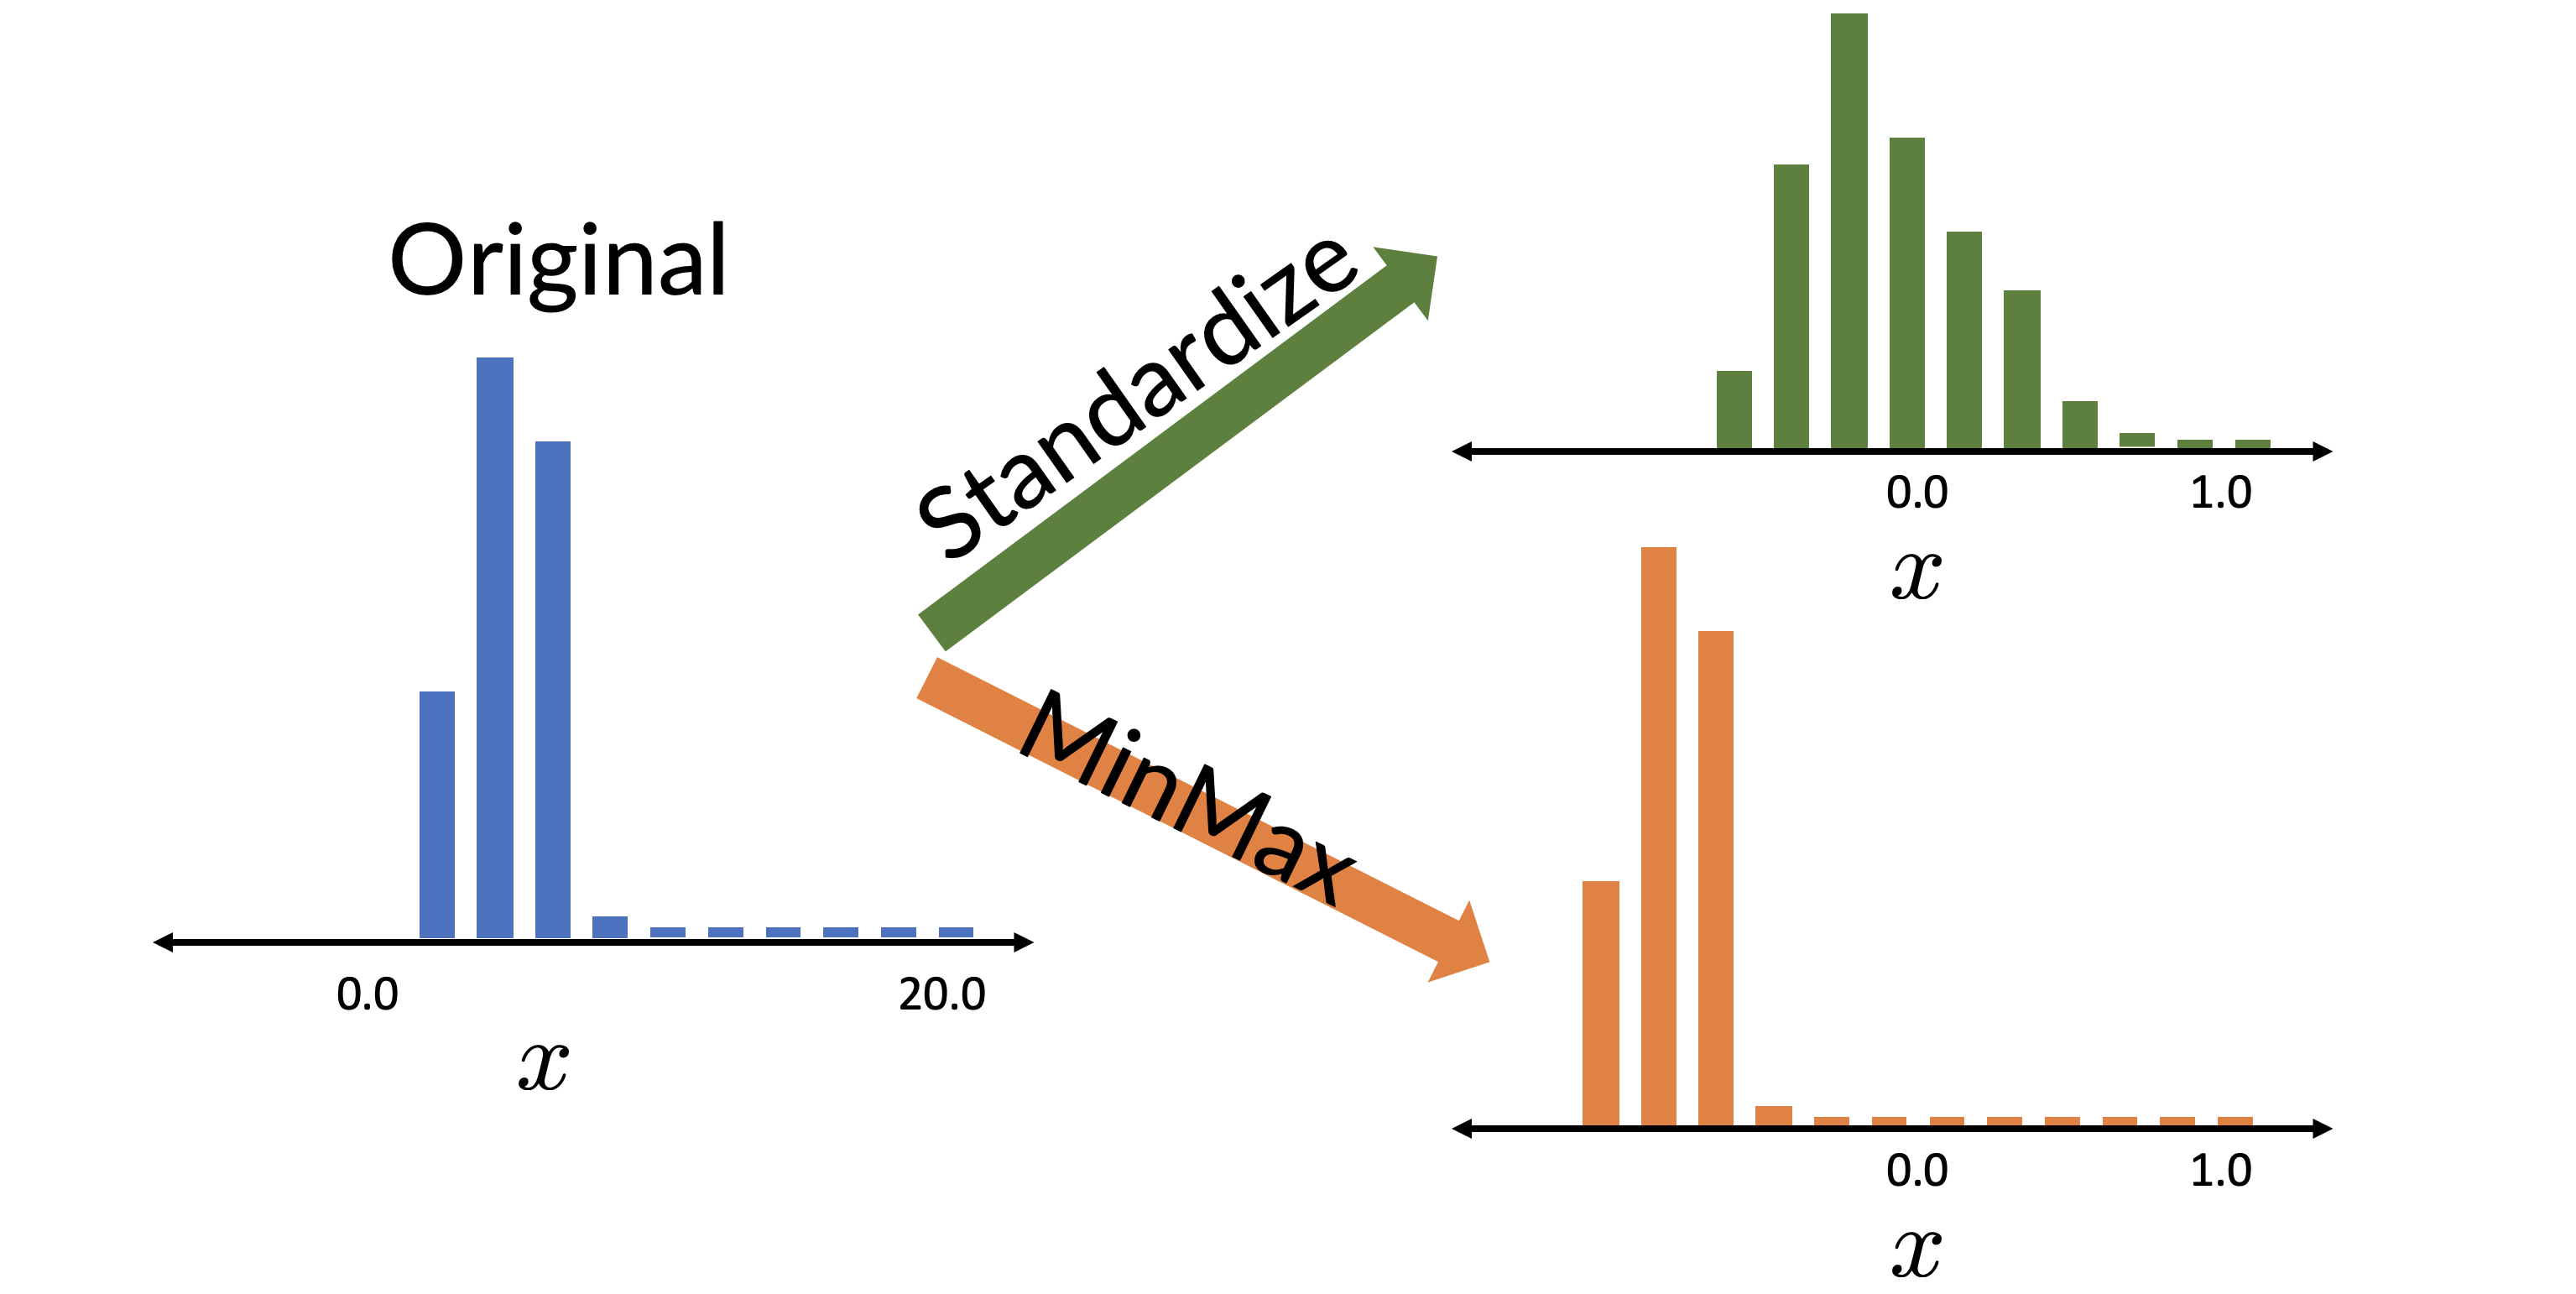

***

### D. Optimization hyperparameters

<font size=5><center>The method that we conduct gradient descent also impacts the final parameters:

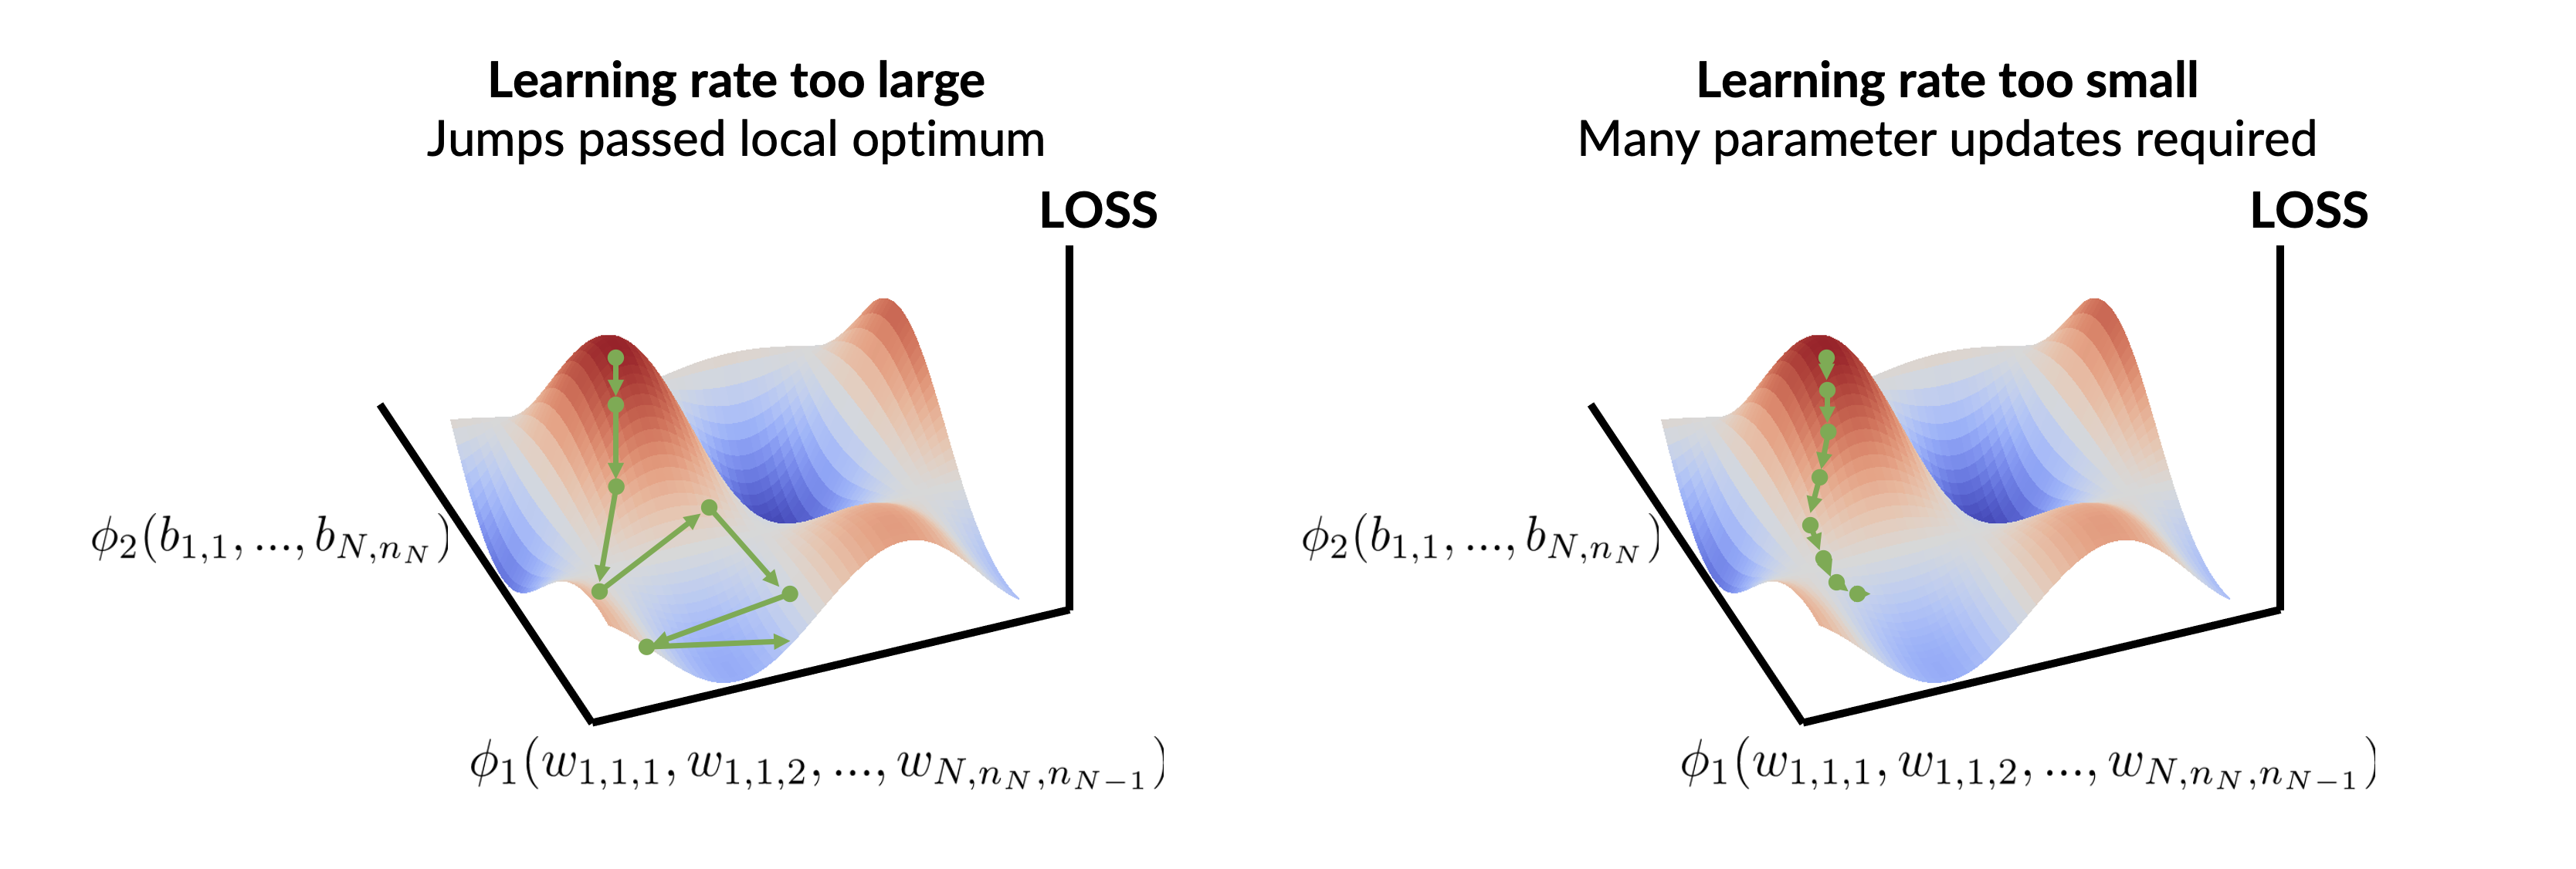

<font size=4>Learning schedule can help e.g. __large learning rate initially and then smaller as training proceeds__. See [here](https://keras.io/api/optimizers/#learning-rate-decay--scheduling) for implementation.

<font size=5><center>There are also many types of optimizers __other than gradient descent__. We might chose to consider not just the gradient but the __momentum__ such as the optimizer [RMSProp](https://keras.io/api/optimizers/rmsprop/). 

<font size=4> A very commonly used optimizer is the [Adam optimizer](https://keras.io/api/optimizers/adam/) that uses first and second order moments:

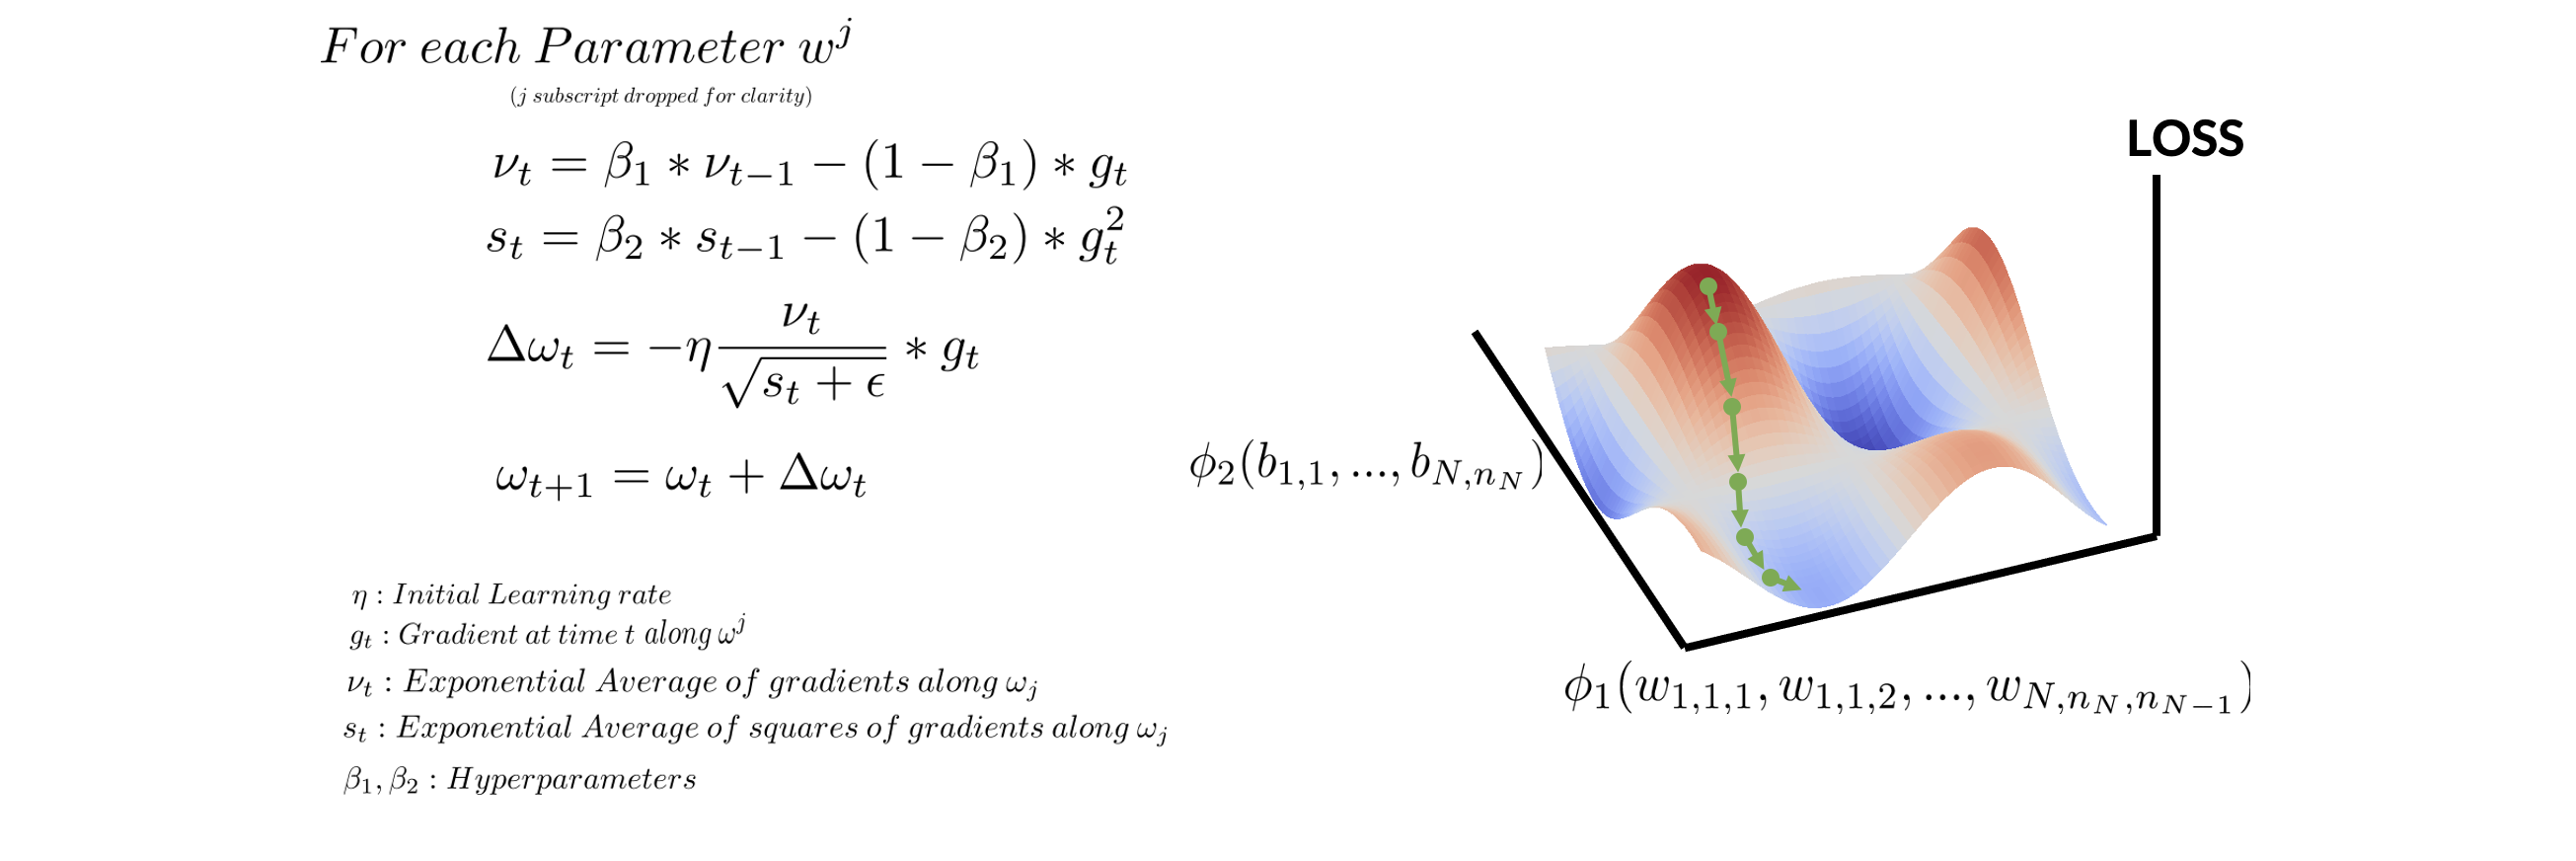

<font size=4>We can specify the optimzer like so:

In [33]:
optimizer = ks.optimizers.Adam(learning_rate=.01, beta_1=.9, beta_2=.999)
model.compile(optimizer=optimizer, loss='mse')

***

### E. Regularization hyperparameters

<font size=5><center>Remember how regularization can help with overfitting? __We almost always want to regularize neural networks.__

<font size=4>The first way you are familiar with, using L1 and L2 regularization like we did for linear regression (Lasso and Ridge Regression). Specifically, our loss function changes from its basic expresion (like MSE) to contain the regularization term:

<font size=4>$$loss = MSE + \lambda\Sigma_iw_i^2$$

<font size=4>You can see that this new regularization term with strength $\lambda$ is still differentiable in terms to the weights, so we can backpropegate. This has the effect of preventing a single weight from dominating unless it truly causes the MSE to get significantly better.

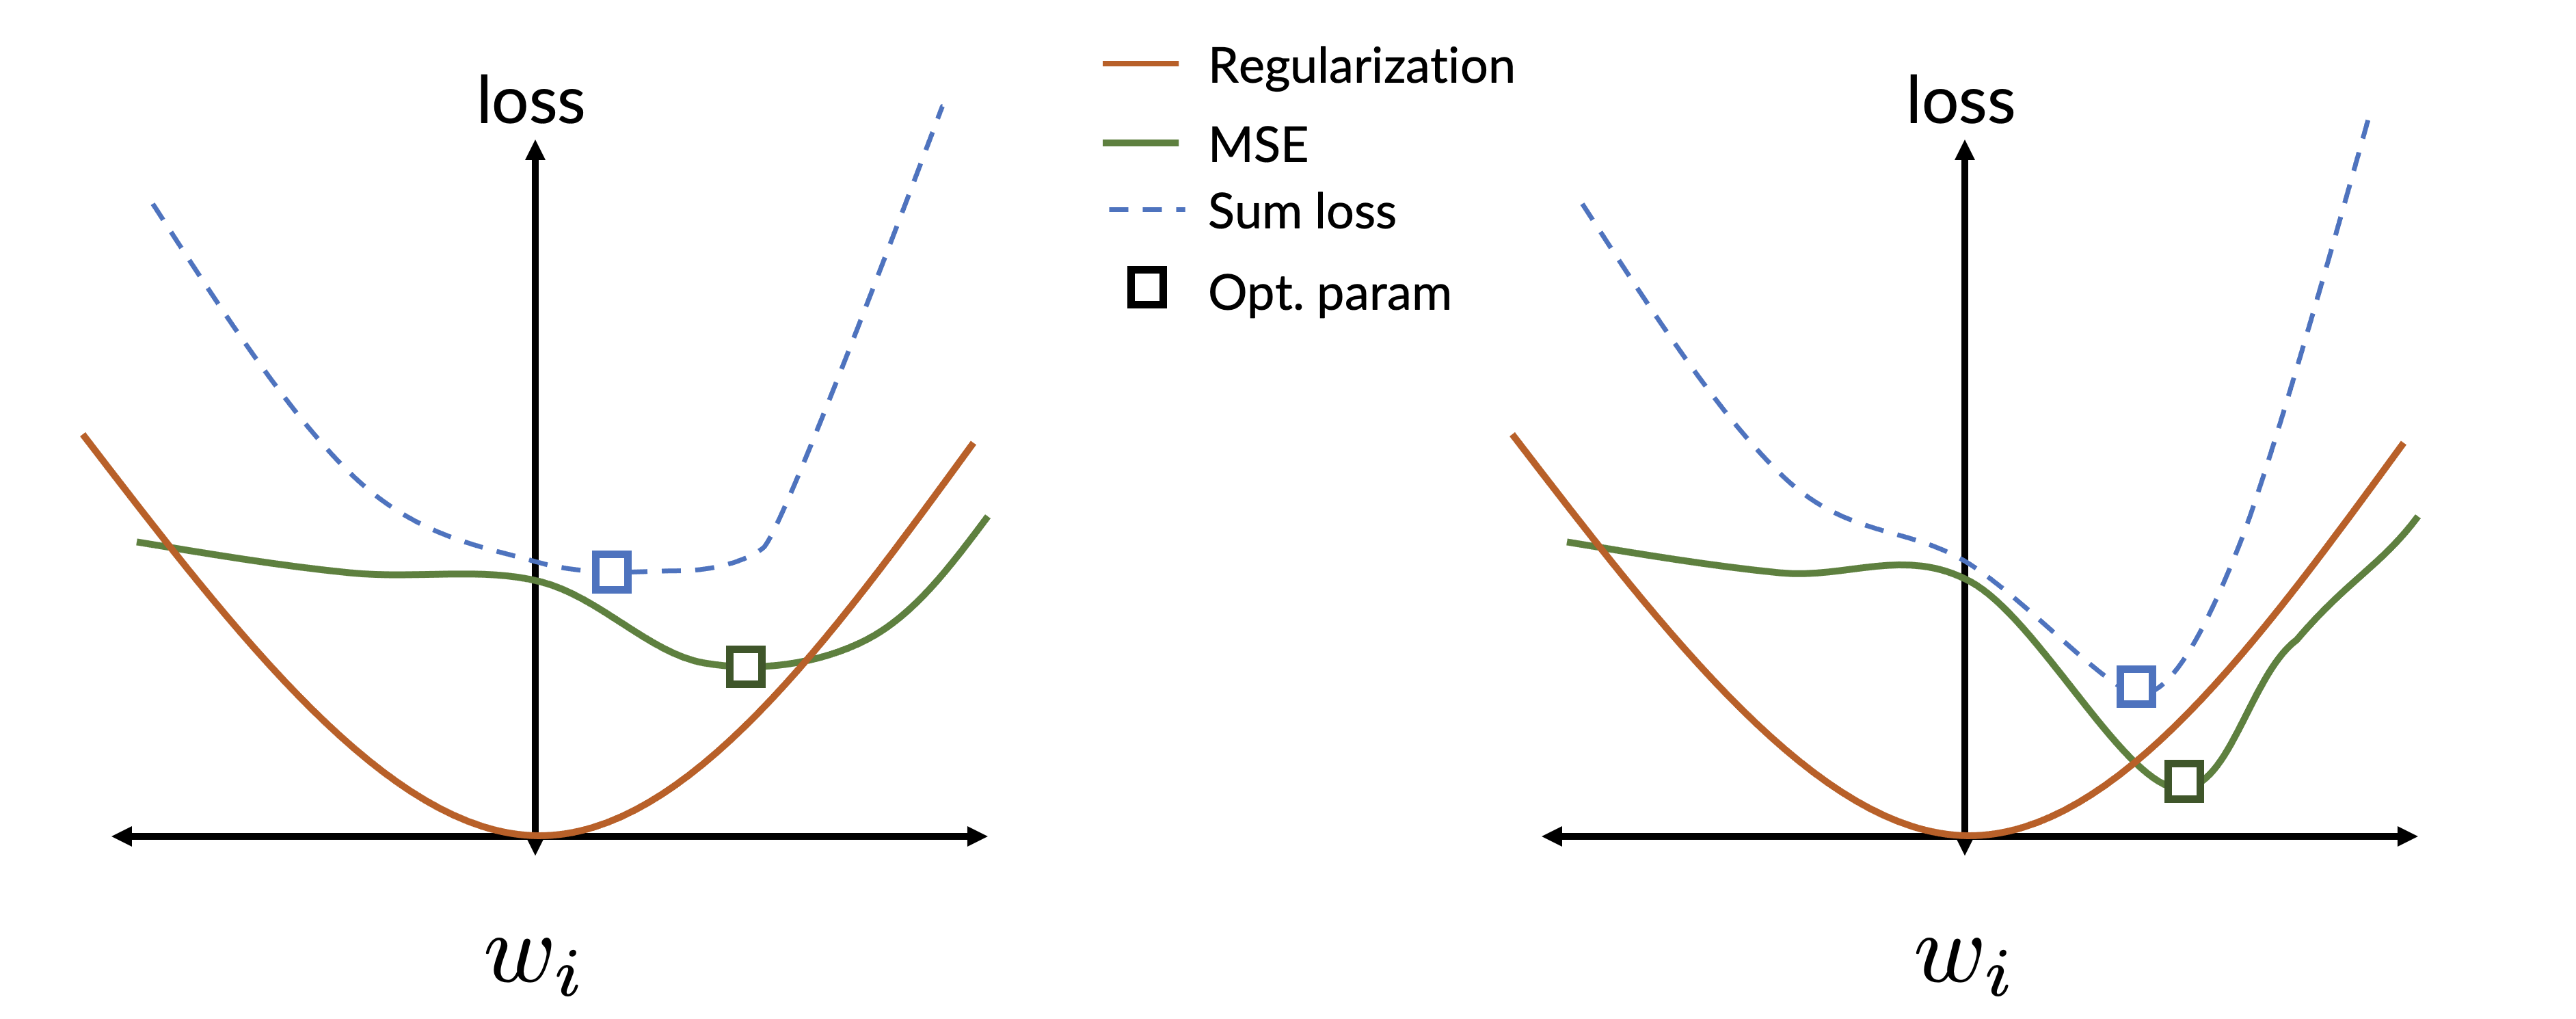

<font size=5><center>Without regularization, both cases would result in the same optimum value of $w_i$.

<font size=4>We can do this in keras when we define the layer:

In [34]:
ks.layers.Dense(5, 
                kernel_regularizer=ks.regularizers.L1L2(l2=.01)
               )

<font size=5><center>There is another method __unique to NNs called dropout__.

<font size=4>Here, a random subset of neurons are turned off during training, so the network cannot rely on one neuron to dominate or decide the prediction.

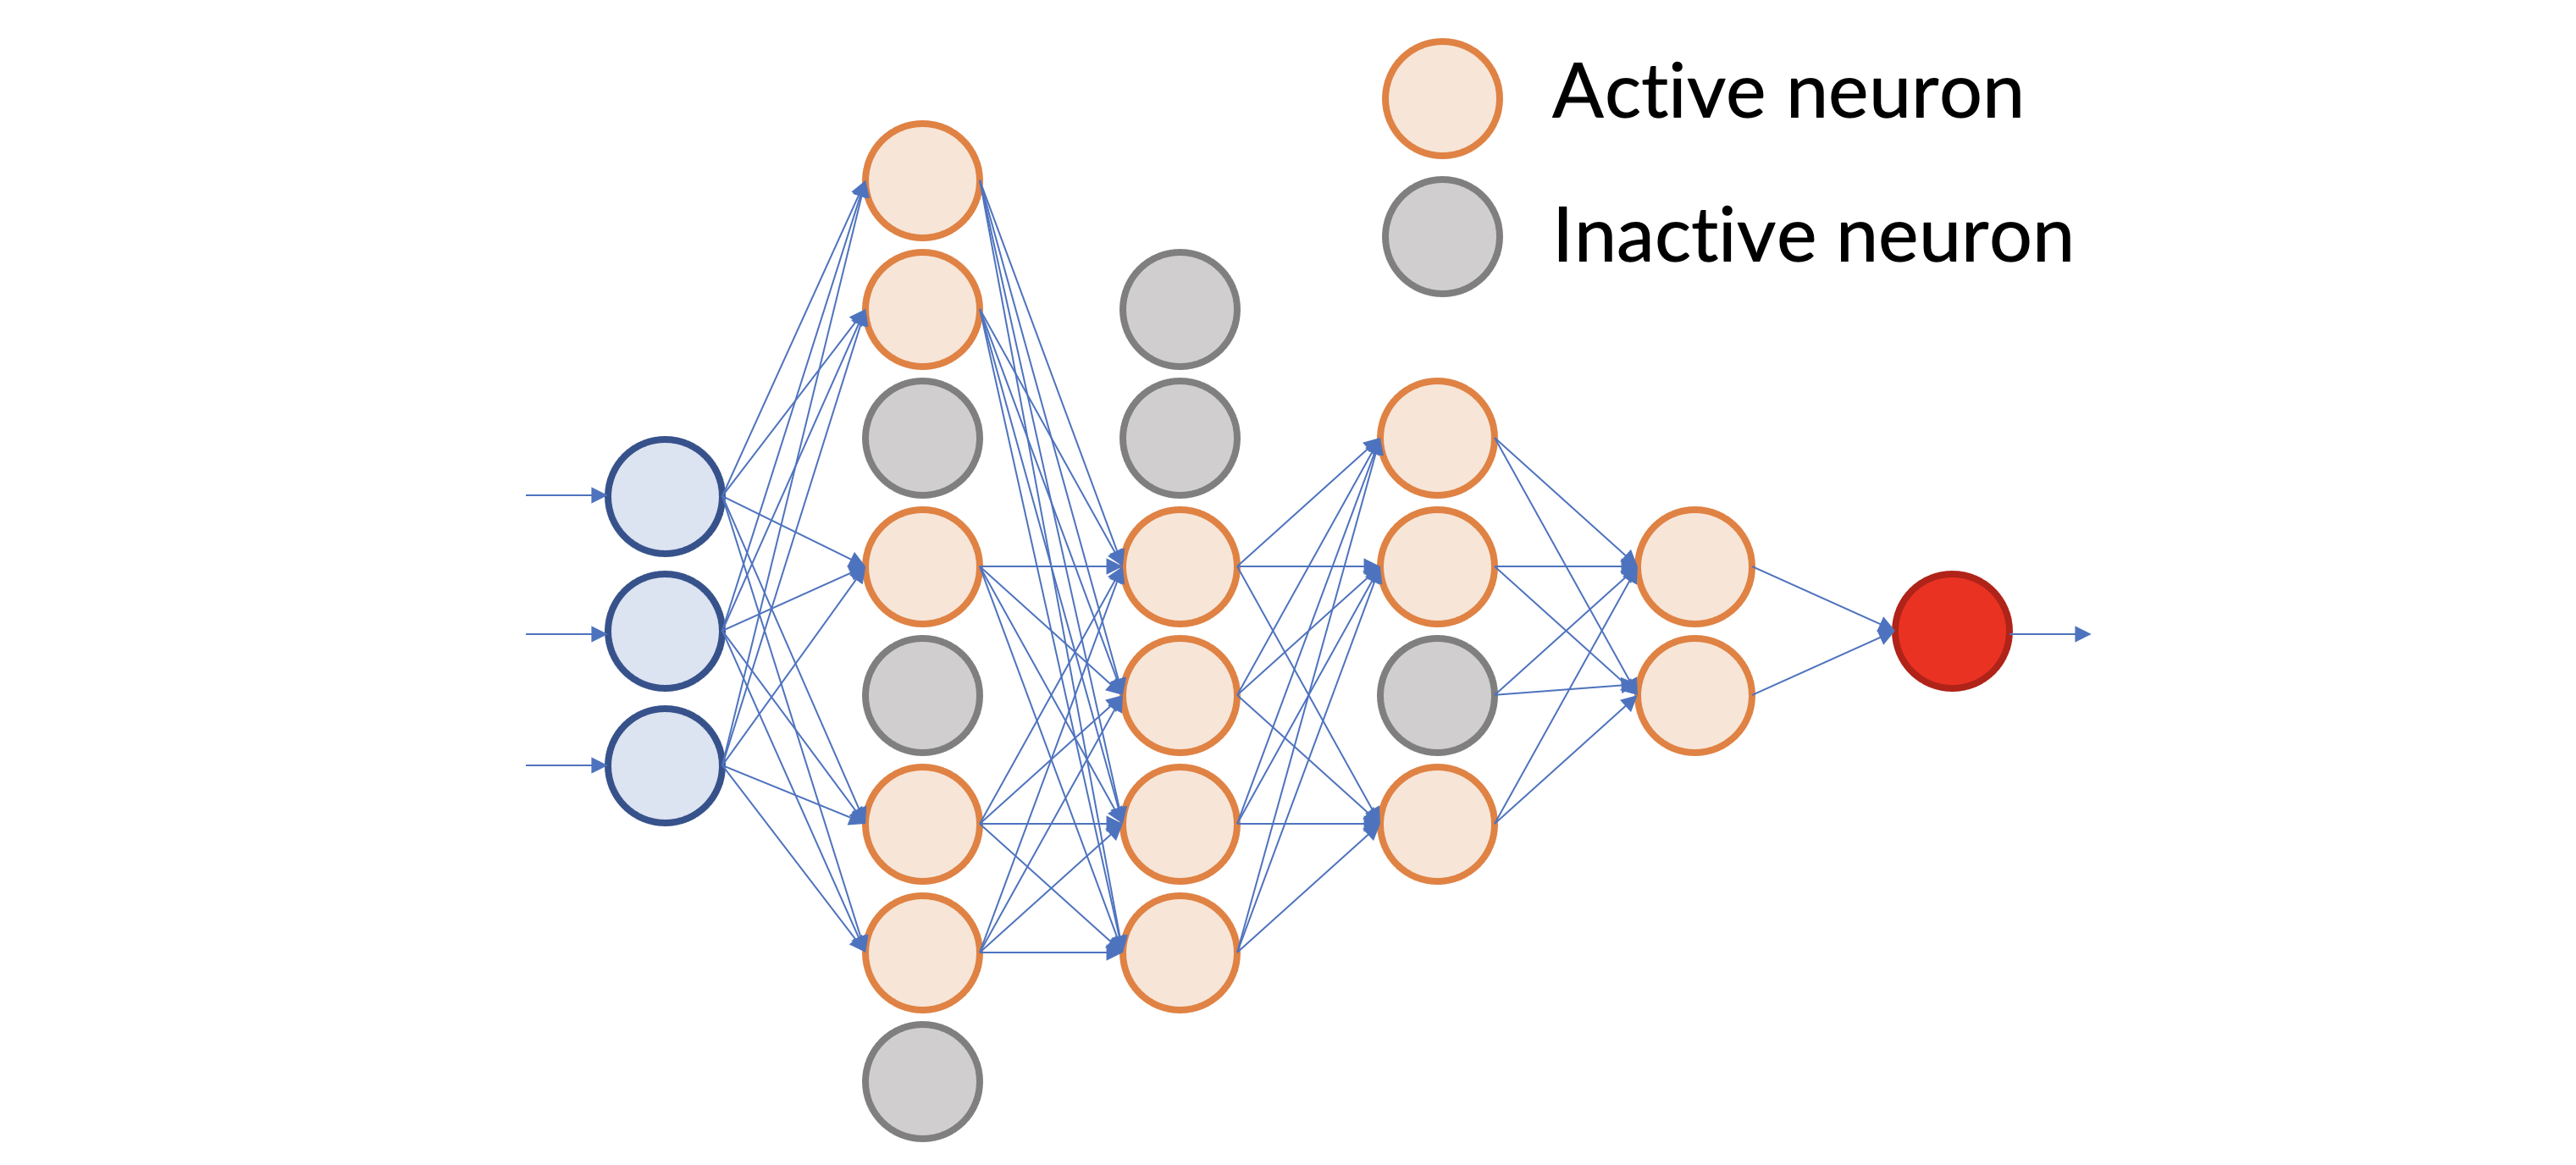

<font size=4>In the next parameter update, __the subset of nuerons that is turned off changes__. We can add drop out layer-by layer just like L1/2 regularization by adding a dropout layer after the dense layer

In [35]:
model = ks.Sequential()

model.add(ks.layers.Dense(5, activation='relu'))
model.add(ks.layers.Dropout(rate=.1)) # 10% of neurons are turned off

<font size=4> Let's retry training with dropout.

In [37]:
def build_basic_dnn():
    """Create a simple dense neural network with 3 hidden layers of 3, 4, 5 neurons
    and an output layer.
    
    Returns:
        model (ks.model): 
            the defined keras model
    """
    ## initialize the model
    # "sequential" is the most basic type of NN, the one we introduced, where
    # information flows from left to right sequentially
    model = ks.Sequential() 
    
    ## Add the three hidden layers of 92, 64, 12 neurons each
    model.add(
        ks.layers.Dense(32, activation='tanh') # Remember the tanh activation function?
    )
    model.add(ks.layers.Dropout(0.2))
    
    model.add(
        ks.layers.Dense(24, activation='tanh')
    )
    model.add(ks.layers.Dropout(0.2))
    
    model.add(
        ks.layers.Dense(12, activation='tanh')
    )
    model.add(ks.layers.Dropout(0.2))
    
    ## add the output layer
    #. it is just 1 neuron
    #. Notice the activation function?
    model.add(ks.layers.Dense(1))
    
    ## compile the model
    #. using MSE as the loss function
    model.compile(loss = 'MSE')
    
    #. tell the model how many features to expect
    model.build(input_shape=train_X.shape)
    
    ## return the compiled model
    return model

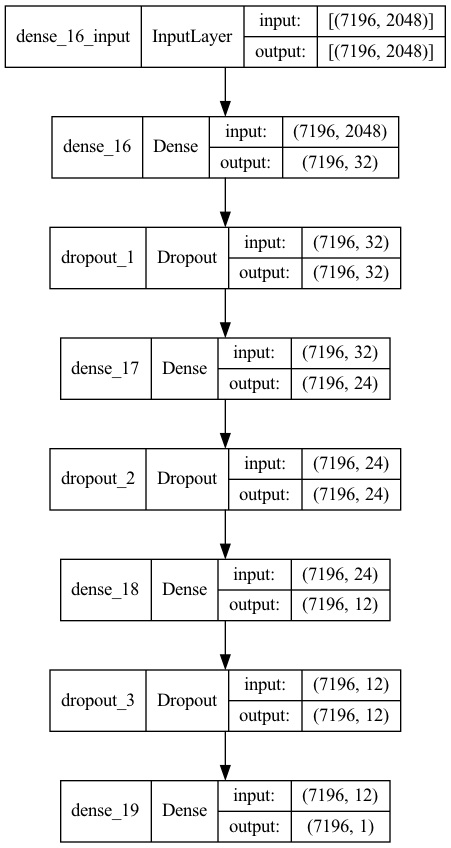

In [38]:
model = build_basic_dnn()
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [39]:
## here the batch size is smaller than the total dataset
history = model.fit(
    train_X, train_y, validation_data=(val_X, val_y), epochs=200, batch_size=32, verbose=2)

Epoch 1/200
225/225 - 1s - loss: 0.3815 - val_loss: 0.1163 - 768ms/epoch - 3ms/step
Epoch 2/200
225/225 - 0s - loss: 0.2410 - val_loss: 0.0612 - 375ms/epoch - 2ms/step
Epoch 3/200
225/225 - 0s - loss: 0.1857 - val_loss: 0.0710 - 377ms/epoch - 2ms/step
Epoch 4/200
225/225 - 0s - loss: 0.1452 - val_loss: 0.0613 - 392ms/epoch - 2ms/step
Epoch 5/200
225/225 - 0s - loss: 0.1318 - val_loss: 0.0580 - 386ms/epoch - 2ms/step
Epoch 6/200
225/225 - 0s - loss: 0.1214 - val_loss: 0.0445 - 377ms/epoch - 2ms/step
Epoch 7/200
225/225 - 0s - loss: 0.1099 - val_loss: 0.0476 - 377ms/epoch - 2ms/step
Epoch 8/200
225/225 - 0s - loss: 0.1032 - val_loss: 0.0445 - 367ms/epoch - 2ms/step
Epoch 9/200
225/225 - 0s - loss: 0.0979 - val_loss: 0.0492 - 362ms/epoch - 2ms/step
Epoch 10/200
225/225 - 0s - loss: 0.0892 - val_loss: 0.0413 - 371ms/epoch - 2ms/step
Epoch 11/200
225/225 - 0s - loss: 0.0864 - val_loss: 0.0408 - 383ms/epoch - 2ms/step
Epoch 12/200
225/225 - 0s - loss: 0.0792 - val_loss: 0.0397 - 376ms/epoch 

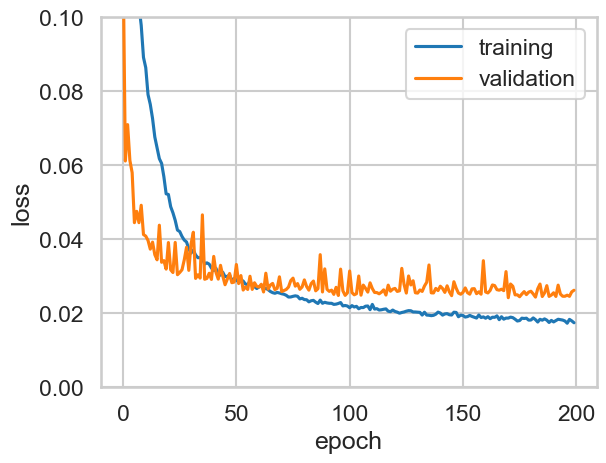

In [40]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_ylim(0,.1)
ax.legend()

<font size=4>With regularization, not only are we no longer overfitting at ~40 epochs, but it also seems like we could train more and get even better.

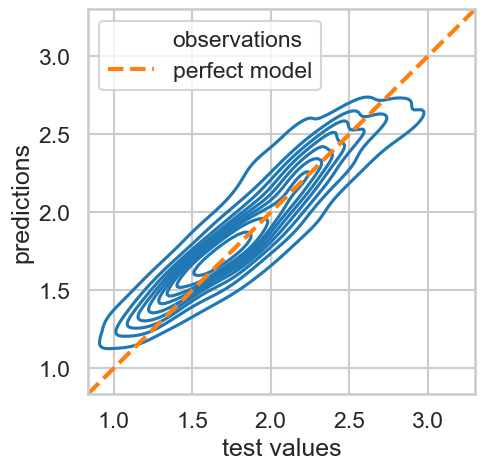

In [55]:
test_predictions = model.predict(test_X)
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(x=test_y.flatten(), y=test_predictions.flatten(), ax=ax, label='observations')
min_val = min([min(test_y), min(test_predictions)])
max_val = max([max(test_y), max(test_predictions)])
ax.plot([min_val, max_val], [min_val, max_val], c='tab:orange', ls='--', lw=3, label='perfect model')

ax.set_xlim((min_val, max_val))
ax.set_ylim((min_val, max_val))
ax.set_xlabel('test values')
ax.set_ylabel('predictions')
ax.legend()

***

<font size=5><center>One final way to stop overfitting is __early stopping__.

<font size=4>Here we monitor validation loss, and when it seems like it is starting to consistantly go up again, we stop training.

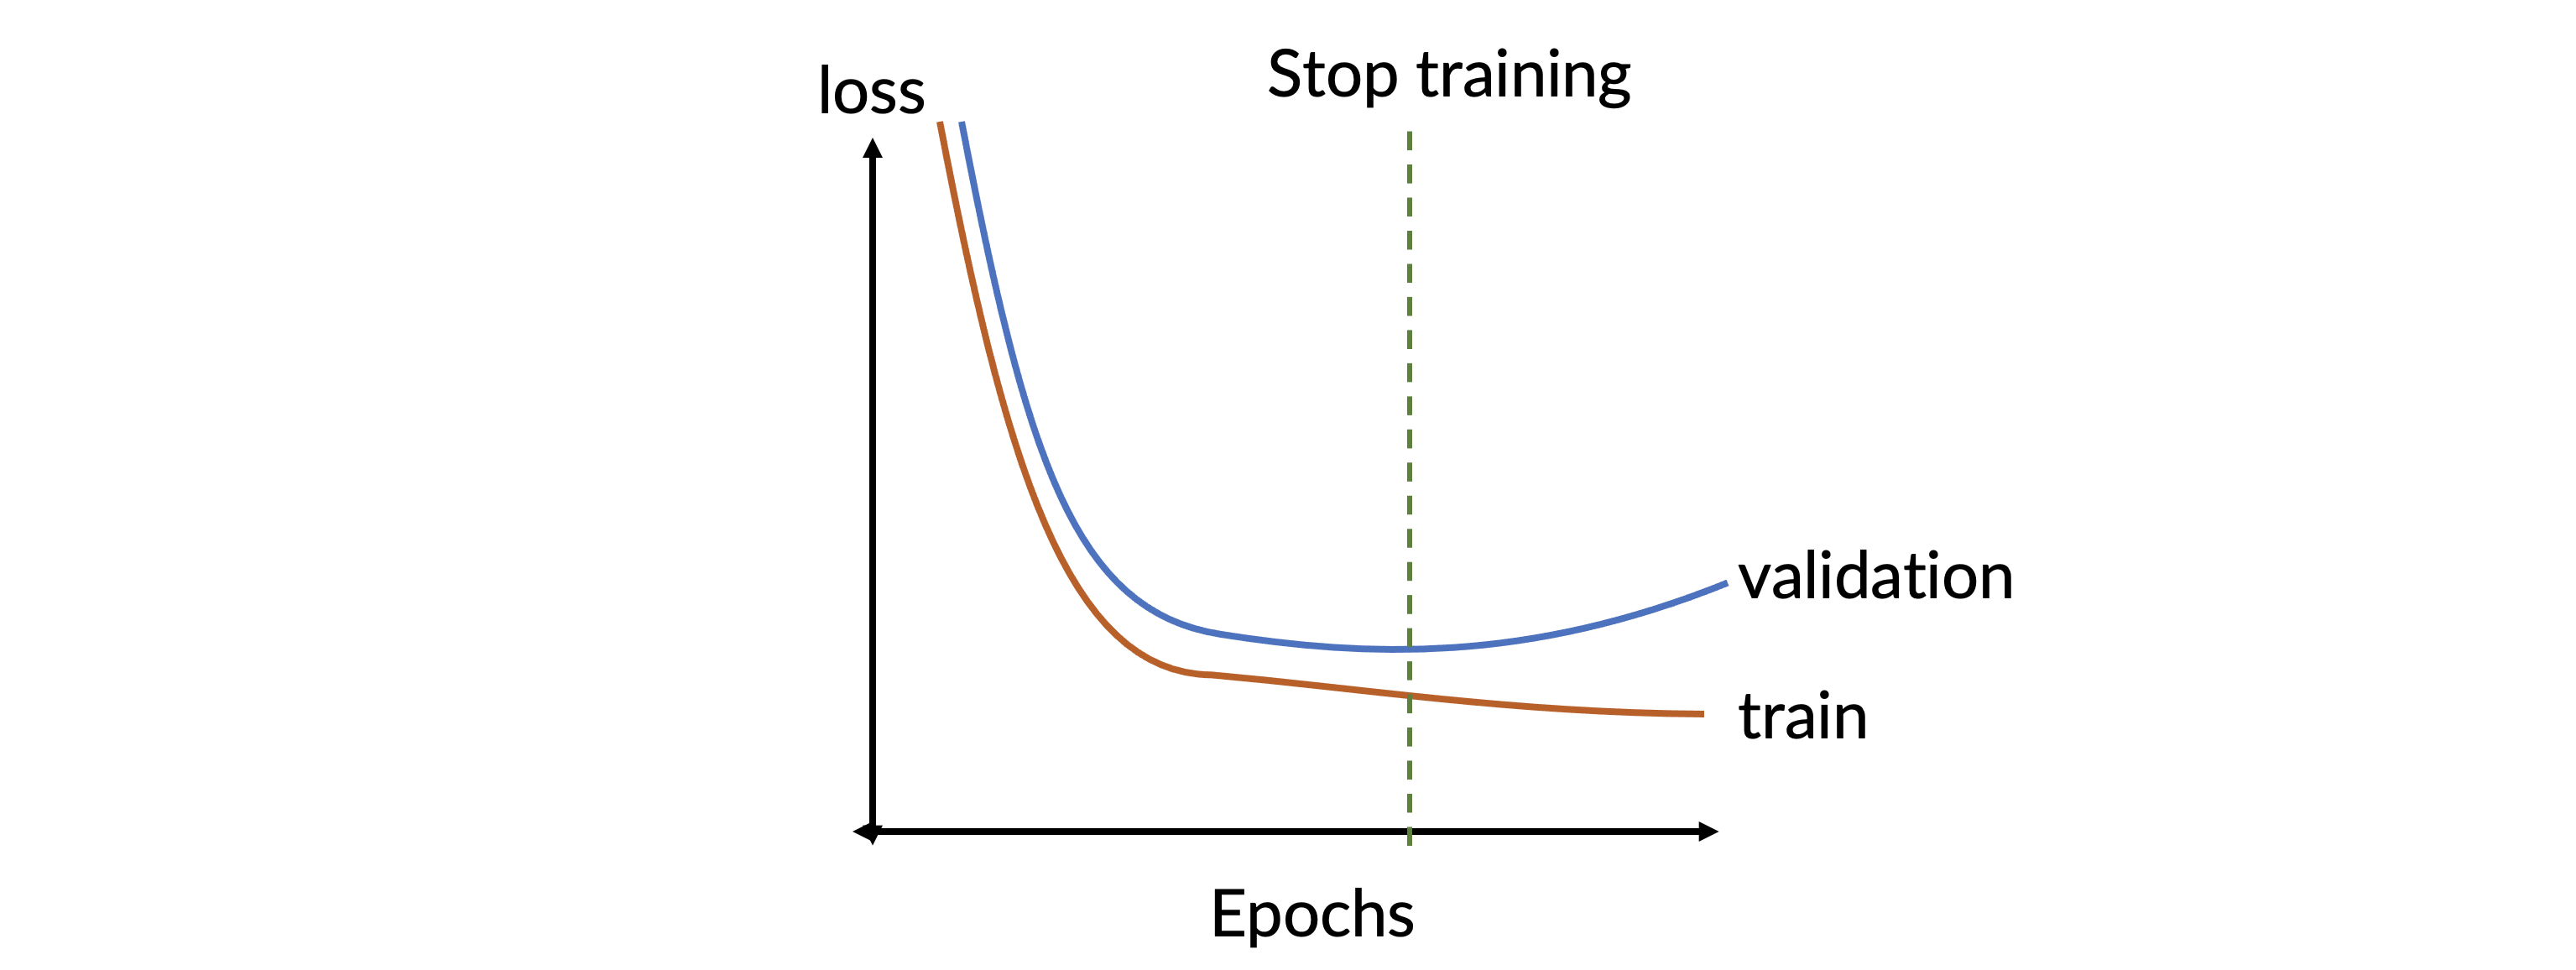

<font size=4> We can do it in `keras` by adding a "callback" to the training 

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_X, train_y, val_data=(val_X, val_y), callbacks=[callback])

***

### E. _Poll_: Which model is better?

<font size=4>Consider two models that are identical except in the following ways:
    
1. <font size=4>Uses __tanh__ activation function, stopped by __early stopping at 25 epochs__ with __training loss of 0.5 and val loss of 0.7__
    
2. <font size=4>Uses __sigmoid__ activation function, stopped by __early stopping at 15 epochs__ with __training loss of 0.8 and val loss of 0.6__
    
<font size=4>__Should you use the tanh activation function or the sigmoid activation function__?

***

### F. Train a classifier

<font size=4> Create a new model function that __does classification__ on whether or not the energy gap is __one of four classes corresponding to the quantiles in the dev data__, e.g. if the value of y is less than the 25th percentile, the example is Class 0, if between 25% and 50%, it is Class 1, etc. Train it and monitor validation loss for 50 epochs. Everything you need to know was linked or discussed in this notebook.
    
<font size=4> *Hints*:

- <font size=4> The target `y` matrices will need to change. For 4-class classification, __it should be one-hot encoded__. What does this mean about the number of output neurons? (See table above regarding output neurons)
    - The long way: compute the percentiles, for each class create a boolean column vector of whether or not the data is in that bin, horizontally stack the columns to create 4 target columns
    - The easy way: use sklearn's [KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html)

 
    
- <font size=4> The loss function will have to change to be something useful for classification.
    
- <font size=4> The output layer activation needs to change.

> <span style='color:red'> remove for lec

<font size=4> The long way

In [64]:
def get_class_matrix(y_vec, percentiles):
    class_1 = y_vec < percentiles[0]
    class_2 = np.logical_and(y_vec > percentiles[0], y_vec < percentiles[1])
    class_3 = np.logical_and(y_vec > percentiles[1], y_vec < percentiles[2])
    class_4 = y_vec > percentiles[2]
    return np.hstack([class_1, class_2, class_4, class_4]).astype(int)

In [62]:
percentiles = np.percentile(dev_y, [25, 50, 75])
print(f"Percentile thresholds: {percentiles}")

Percentile thresholds: [1.59039197 1.86235817 2.15366405]


In [66]:
train_y_class = get_class_matrix(train_y, percentiles)
val_y_class = get_class_matrix(val_y, percentiles)
print(f"new training data shape: {train_y_class.shape}")

new training data shape: (7196, 4)


<font size=4> The easy way

In [70]:
encoder = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')
encoder.fit(dev_y)
train_y_class = encoder.transform(train_y)
val_y_class = encoder.transform(val_y)
print(f"new training data shape: {train_y_class.shape}")

new training data shape: (7196, 4)


<font size=4> New model function

In [77]:
def build_class_dnn():
    model = ks.Sequential() 
    model.add(
        ks.layers.Dense(32, activation='tanh')
    )
    model.add(ks.layers.Dropout(0.2))
    model.add(
        ks.layers.Dense(24, activation='tanh')
    )
    model.add(ks.layers.Dropout(0.2))
    model.add(
        ks.layers.Dense(12, activation='tanh')
    )
    model.add(ks.layers.Dropout(0.2))
    
    # HERE WE CHANGE THE OUTPUT SHAPE TO BE 4 NEURONS FOR 4 CLASSES
    # AND WE USE SOFTMAX
    model.add(ks.layers.Dense(train_y_class.shape[1], activation='softmax'))
    
    # HERE WE NEED LOG LOSS
    model.compile(loss = 'categorical_crossentropy')
    
    #. tell the model how many features to expect
    model.build(input_shape=train_X.shape)
    
    ## return the compiled model
    return model

In [78]:
model = build_class_dnn()

In [79]:
history = model.fit(
    train_X, train_y_class, validation_data=(val_X, val_y_class), epochs=50, batch_size=32, verbose=2)

Epoch 1/50
225/225 - 1s - loss: 1.1873 - val_loss: 0.9135 - 777ms/epoch - 3ms/step
Epoch 2/50
225/225 - 0s - loss: 0.9815 - val_loss: 0.8501 - 371ms/epoch - 2ms/step
Epoch 3/50
225/225 - 0s - loss: 0.9135 - val_loss: 0.8059 - 374ms/epoch - 2ms/step
Epoch 4/50
225/225 - 0s - loss: 0.8563 - val_loss: 0.7794 - 378ms/epoch - 2ms/step
Epoch 5/50
225/225 - 0s - loss: 0.8181 - val_loss: 0.7571 - 370ms/epoch - 2ms/step
Epoch 6/50
225/225 - 0s - loss: 0.7935 - val_loss: 0.8517 - 375ms/epoch - 2ms/step
Epoch 7/50
225/225 - 0s - loss: 0.7855 - val_loss: 0.7418 - 382ms/epoch - 2ms/step
Epoch 8/50
225/225 - 0s - loss: 0.7571 - val_loss: 0.7481 - 373ms/epoch - 2ms/step
Epoch 9/50
225/225 - 0s - loss: 0.7396 - val_loss: 0.7344 - 369ms/epoch - 2ms/step
Epoch 10/50
225/225 - 0s - loss: 0.7267 - val_loss: 0.7941 - 378ms/epoch - 2ms/step
Epoch 11/50
225/225 - 0s - loss: 0.7013 - val_loss: 0.7132 - 370ms/epoch - 2ms/step
Epoch 12/50
225/225 - 0s - loss: 0.7011 - val_loss: 0.7381 - 377ms/epoch - 2ms/step
E

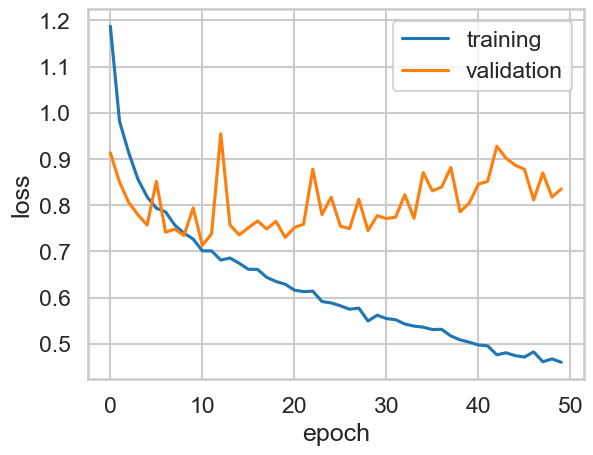

In [81]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='training')
ax.plot(history.history['val_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

In [85]:
val_class_probs = model.predict(val_X)
val_class_probs

array([[4.8405610e-04, 2.4991974e-02, 8.1454682e-01, 1.5997715e-01],
       [9.6245009e-01, 3.6732115e-02, 7.7090226e-04, 4.6872665e-05],
       [3.4858782e-02, 8.8239831e-01, 8.1773818e-02, 9.6908276e-04],
       ...,
       [3.2508662e-01, 6.3407797e-01, 3.9913811e-02, 9.2153769e-04],
       [1.5533154e-01, 8.0739748e-01, 3.6718160e-02, 5.5289530e-04],
       [4.3092150e-02, 5.4026347e-01, 3.8960648e-01, 2.7037878e-02]],
      dtype=float32)

In [88]:
val_class_preds = val_class_probs.argmax(axis=1)
val_y_labels = val_y_class.argmax(axis=1)

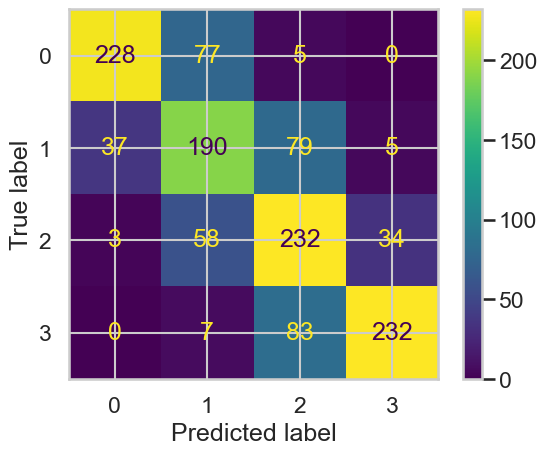

In [89]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(val_y_labels, val_class_preds)

***

| Hyperparameter | Function | Apx impact on cost | Apx impact on model capability |
| -------------- | -------- | ------------------ | ------------------------------ |
| Layers and layer counts | Determines how much nonlinear math we can do | High | High |
| Activation function | Nonlinearity of the model | High | Medium |
| Param initialization | Where on the lost surface we start, which local optimum we can find | Medium | Low |
| Learning rate | How much we change parameters per step | High | High |
| Other optimizer params | Momentum, smoothing of gradient descent | Med | Med |
| Loss function | how the model parameters are evaluated | Low | High |
| Number of training epochs | How many times we see all of the data | High | High |
| Batch size | Defines how much data we see before a param update | High | Low |
| Regularization strengths | Keep model from overfitting | None | High | 
| Early stopping | Keep final model from overfitting | Med | Med |

Among others...

***

## Summary

<font size=4> - We introduced the __anatomy of a neural network__, and trained a small NN regressor using keras
    
<font size=4> - We __discussed some pros and cons of NNs__ and showed __how to identify overfitting__
    
<font size=4> - We discussed some of the major hyperparameters for NNs
    
<font size=4> - We used NNs for classification

<font size=5><center><span style='color:orange'>A final note....</span>

<font size=4>Deep Learning is all the rage, but it also has some significant challenges. __It is expensive to train__ and __difficult to tune__ which adds to the cost even further.

<font size=5><center>__MAKE SURE__ that you can't use a simpler model effectively for your task before you use NNs, Many times people have a task that can be done better with XGBoost and they waste time and energy on NNs. __Only use NNs__ if your dataset is too big for other models, or the features you can engineer were not effective when used with simpler models.

## A challenge for you...

<font size=4>Conduct __cross validation__ of a neural network regressor using this data, and __use every hyperparameter we discussed here__.